In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import stats
from scipy.ndimage import label

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
def load_and_preprocess_images(directory_path, size=(200, 200), max=350):
    count = 0
    images = []
    try:
        for filename in os.listdir(directory_path):
            if filename.endswith(".png"):
                file_path = os.path.join(directory_path, filename)
                # img = Image.open(file_path)
                img = Image.open(file_path).convert('L')  # Convert to grayscale (original image)
                img_array = np.array(img)
                images.append(img_array)
                count += 1
                if count >= max:
                  break

        if len(images) == 0:
          print(f"No images found in directory: {output_directory_dots}")

        images = np.array(images)
        return images

    except Exception as e:
        print(f"Error loading and preprocessing images: {e}")
        return None

def create_labels(images, label):
    labels = [label] * len(images)
    return np.array(labels)

def split_dataset(images, labels, test_size=0.3):
    try:
        train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=test_size, random_state=42)
        return train_images, test_images, train_labels, test_labels
    except ValueError as ve:
        print(f"Error splitting dataset: {ve}")
        return None, None, None, None

In [ ]:
def nonZerosInImage(x):
  # Get indices of non-zero elements
  non_zero_indices = np.nonzero(x)
  non_zero_images = x
  # print("Indices of non-zero elements:", non_zero_indices)
  print("Non-zero elements:", non_zero_images[non_zero_indices])

In [ ]:
def resizeImages(x):
    resized_images = []

    # Iterate over each image in the original array
    for img_array in x:
      # Convert numpy array back to PIL Image to use the resize method
      img = Image.fromarray(img_array)
      # img = img.convert('L') Already done at time of loading the image

      # img_resized = img.resize((200, 200), Image.ANTIALIAS) # Deprecated
      img_resized = img.resize((200, 200), Image.Resampling.LANCZOS)

      # Convert the resized image back to numpy array
      img_resized_array = np.array(img_resized)

      # Append the resized array to the new list
      resized_images.append(img_resized_array)

    # Convert the list of resized image arrays back to a single numpy array
    resized_images = np.array(resized_images)

    return resized_images

In [ ]:
def plot_non_zero_distribution(img_array):
    # Extract non-zero values
    non_zero_values = img_array[img_array > 0]

    # Plot histogram of non-zero values
    plt.figure(figsize=(4, 4))
    plt.hist(non_zero_values, bins=30, color='blue', alpha=0.7)
    plt.title('Histogram of Non-Zero Pixel Values')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [ ]:
def analyze_pixel_intensity(img_array, threshold=2):
    # intensity_stats = []

    # Apply threshold to isolate dots
    dot_mask = img_array > threshold
    dot_intensities = img_array[dot_mask]

    # Calculate statistics if there are any dots
    if dot_intensities.size > 0:
        min_intensity = int(np.min(dot_intensities))
        max_intensity = int(np.max(dot_intensities))
        mean_intensity = int(np.mean(dot_intensities))
        median_intensity = int(np.median(dot_intensities))
        percentile_5 = int(np.percentile(dot_intensities, 5))
        percentile_10 = int(np.percentile(dot_intensities, 10))
        percentile_25 = int(np.percentile(dot_intensities, 25))
        percentile_50 = int(np.percentile(dot_intensities, 50))
        percentile_75 = int(np.percentile(dot_intensities, 75))
        percentile_90 = int(np.percentile(dot_intensities, 90))
        percentile_95 = int(np.percentile(dot_intensities, 95))

        stats = {
            'Mean': mean_intensity,
            'Median': median_intensity,
            'Min': min_intensity,
            '5th %': percentile_5,
            '10th %': percentile_10,
            '25th %': percentile_25,
            '50th %': percentile_50,
            '75th %': percentile_75,
            '90th %': percentile_90,
            '95th %': percentile_95,
            'Max': max_intensity
        }
    else:
        stats = {
            'Mean': None,
            'Median': None,
            'Min': None,
            '5th %': None,
            '10th %': None,
            '25th %': None,
            '50th %': None,
            '75th %': None,
            '90th %': None,
            '95th %': None,
            'Max': None
        }

    # intensity_stats.append(stats)

    return stats

In [ ]:
def reset_image_pixels(img_array, threshold=2):
    img_array[img_array < threshold] = 0
    # img_array[img_array >= threshold] = 255

In [ ]:
def count_dots(img_array, threshold=2):
    dot_counts = []

    # Apply threshold
    img_thresholded = np.array(img_array)
    img_thresholded[img_thresholded < threshold] = 0

    # Label connected components
    structure = np.ones((3, 3), dtype=int)  # Define connectivity
    labeled, ncomponents = label(img_thresholded, structure=structure)

    # Append the count of components
    dot_counts.append(ncomponents)

    return dot_counts

In [ ]:
def remove_noise(img_array, threshold=2, min_size=9):
    # Apply threshold to remove low intensity noise
    img_thresholded = np.array(img_array)
    img_thresholded[img_thresholded < threshold] = 0

    # Label connected components with 3x3 connectivity
    # Each unique connected group of non-zero pixels is given a unique label
    structure = np.ones((3, 3), dtype=int)
    labeled_image, ncomponents = label(img_thresholded, structure=structure)

    # Iterate over each component using the labels
    # for component_label in range(1, ncomponents + 1):  # Skip label 0 as it's the background
    #    component_indices = np.where(labeled_image == component_label)
    #    # Check the size of the component to see if the number of pixels it contains is less than min_size (9)
    #    if len(component_indices[0]) < min_size:
    #        # Set pixels of small components to zero
    #        labeled_image[component_indices] = 0

    # Get sizes of each component
    component_sizes = np.bincount(labeled_image.ravel())
    # Create a mask for components that are smaller than the minimum size
    # The bincount array indices correspond to component labels
    small_components = component_sizes < min_size
    small_components[0] = False  # Ignore background which is labeled as 0

    # Use the mask to set small components to 0 in labeled_image
    # np.where replaces indices of small_components that are True with 0
    labeled_image = np.where(small_components[labeled_image], 0, labeled_image)

    # Create a cleaned image where only pixels that are part of larger components are retained
    cleaned_image = np.where(labeled_image > 0, img_array, 0)

    return cleaned_image

In [ ]:
def plot_dot_image_list_statistics(images, threshold=2, dot=True, blank=False):
    # Count dots in each image
    dot_counts = [count_dots(img, threshold)[0] for img in images]

    if threshold > 0:
        # Reset image pixels
        reset_image_pixels(images, threshold)

    # Calculate statistics
    mean_dots = np.mean(dot_counts)
    median_dots = np.median(dot_counts)
    percentile_5 = np.percentile(dot_counts, 5)
    percentile_10 = np.percentile(dot_counts, 10)
    percentile_25 = np.percentile(dot_counts, 25)
    percentile_50 = np.percentile(dot_counts, 50)
    percentile_75 = np.percentile(dot_counts, 75)
    percentile_90 = np.percentile(dot_counts, 90)
    percentile_95 = np.percentile(dot_counts, 95)

    highest_count = max(dot_counts)
    lowest_count = min(dot_counts)

    # Print results
    print(f"# images: {images.shape[0]} Mean number of dots: {mean_dots:.2f} Median: {median_dots} Highest count: {highest_count} Lowest count: {lowest_count}")
    if dot:
      print(f"5th %: {percentile_5:.2f} 10th: {percentile_10:.2f} 25th: {percentile_25:.2f} 50th: {percentile_50:.2f} 75th: {percentile_75:.2f} 90th: {percentile_90:.2f} 95th: {percentile_95:.2f}")

    # Indices
    index_min = np.argmin(dot_counts)
    index_max = np.argmax(dot_counts)
    index_mean = (np.abs(dot_counts - mean_dots)).argmin()
    index_median = (np.abs(dot_counts - median_dots)).argmin()
    index_5th = (np.abs(dot_counts - percentile_5)).argmin()
    index_10th = (np.abs(dot_counts - percentile_10)).argmin()
    index_25th = (np.abs(dot_counts - percentile_25)).argmin()
    index_75th = (np.abs(dot_counts - percentile_75)).argmin()
    index_90th = (np.abs(dot_counts - percentile_90)).argmin()
    index_95th = (np.abs(dot_counts - percentile_95)).argmin()

    # Retrieve images
    images_to_plot = {
        "Min": (images[index_min], index_min, dot_counts[index_min]),
        # "Mean": (images[index_mean], index_mean, dot_counts[index_mean]),
        # "5th Percentile": (images[index_5th], index_5th, dot_counts[index_5th]),
        "10th Percentile": (images[index_10th], index_10th, dot_counts[index_10th]),
        "25th Percentile": (images[index_25th], index_25th, dot_counts[index_25th]),
        "Median": (images[index_median], index_median, dot_counts[index_median]),
        "75th Percentile": (images[index_75th], index_75th, dot_counts[index_75th]),
        "90th Percentile": (images[index_90th], index_90th, dot_counts[index_90th]),
        # "95th Percentile": (images[index_95th], index_95th, dot_counts[index_95th]),
        "Max": (images[index_max], index_max, dot_counts[index_max])
    }

    if dot:
        img_max = 10
    else:
        img_max = 100

    fig, axes = plt.subplots(1, 7, figsize=(21, 3))  # 1 row, 7 columns

    for ax, (title, (img, idx, count)) in zip(axes, images_to_plot.items()):
        if img.max() <= img_max or blank is True:  # Assuming this means the image uses a 0-1 range
           im = ax.imshow(img, cmap=plt.cm.binary)
        else:
           # im = ax.imshow(img, cmap=plt.cm.binary)
           im = ax.imshow(img, cmap=plt.cm.binary, vmin=0, vmax=1)
        # im = ax.imshow(img, cmap='gray', vmin=0, vmax=1) # for images 0-5 or less

        # Setting title and labels
        ax.set_title(title)
        if dot:
          ax.set_xlabel(f'img{idx}, {count} dots, {np.count_nonzero(img)} pixels')
        else:
          ax.set_xlabel(f'img{idx}, {np.count_nonzero(img)} pixels')

        ax.set_xticks([])
        ax.set_yticks([])

        # Add a color bar for each image
        # Create an axis for colorbar to avoid squeezing the main image
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Intensity', rotation=270, labelpad=15)

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [ ]:
def Plot(x, size, p, type = False):
    plt.figure(figsize=(10,size//5*2))
    for i in range(size):  # Display and save the first 5 separated images for rings and dots
      plt.subplot(size//5, 5, i + 1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      if type:
        plt.imshow(x[i], cmap=plt.cm.binary) # for images 0-255
      else:
        plt.imshow(x[i], cmap='gray', vmin=0, vmax=1) # for images 0-5 or less
      plt.axis('off')
      plt.savefig(f"conv_separated_rings_image_{i}.png")
    plt.show()

    # different plot types FOR EVALUATIONS
    # plt.imshow(x, vmin=0, vmax=1, interpolation='none')
    # plt.imshow(x)  # Use cmap='gray' for grayscale images, omit for RGB images
    # plt.imshow(x, cmap='gray_r', origin='upper', vmin=0, vmax=255, interpolation='none')
    # plt.imshow(x, cmap='gray_r', origin='upper', interpolation='none')
    # plt.imshow(x, cmap=plt.cm.binary, vmin=0, vmax=1)
    # plt.imshow(x, cmap='gray', vmin=0, vmax=1)
    # plt.imshow(x, cmap='gray', interpolation='none')
    # plt.imshow(x, cmap='gray', vmin=0, vmax=255, interpolation='none')
    # plt.imshow(x, cmap=plt.cm.binary)
    # plt.imshow(x, cmap='gray', vmin=0, vmax=1, interpolation='none')
    # plt.imshow(x, cmap=plt.cm.binary, vmin=0, vmax=1, interpolation='none')
    # plt.imshow(x, cmap=plt.cm.binary, vmin=0, vmax=255, interpolation='none')

In [ ]:
def plot_image(original_img, resize_img, scaled_img, threshold=2, dot=True, blank=False):

    # Reset image pixels based on threshold (if threshold is 0, then the reset images are same as the input images)
    original_img_reset = np.array(original_img)
    reset_image_pixels(original_img_reset, threshold)
    resize_img_reset = np.array(resize_img)
    reset_image_pixels(resize_img_reset, threshold)
    scaled_img_reset = np.array(scaled_img)
    reset_image_pixels(scaled_img_reset, threshold)

    # Plotting each image with respective titles and labels
    titles = [f'orig: {original_img.shape}', f'orig <{threshold}=0: {original_img.shape}', f'resize: {resize_img.shape}', f'resize <{threshold}=0: {resize_img.shape}',
      f'scaled: {scaled_img.shape}', f'scaled <{threshold}=0: {scaled_img.shape}']
    if dot:
        img_max = 10
        # Label number of dots and number of pixels
        dot_counts = count_dots(original_img, 0)[0]
        remove_noise_dot_counts = count_dots(original_img, threshold)[0]
        small_dot_counts = count_dots(resize_img, 0)[0]
        remove_noise_small_dot_counts = count_dots(resize_img, threshold)[0]
        scaled_dot_counts = count_dots(scaled_img, 0)[0]
        remove_noise_scaled_dot_counts = count_dots(scaled_img, threshold)[0]
        xlabels = [f'dots: {dot_counts} non-zeros: {np.count_nonzero(original_img)}', f'dots: {remove_noise_dot_counts} non-zeros: {np.count_nonzero(original_img_reset)}',
          f'dots: {small_dot_counts} non-zeros: {np.count_nonzero(resize_img)}', f'dots: {remove_noise_small_dot_counts} non-zeros: {np.count_nonzero(resize_img_reset)}',
          f'dots: {scaled_dot_counts} non-zeros: {np.count_nonzero(scaled_img)}', f'dots: {remove_noise_scaled_dot_counts} non-zeros: {np.count_nonzero(scaled_img_reset)}']
    else:
        img_max = 100
        # Label number of rings (not implemented yet) and number of pixels
        xlabels = [f'non-zeros: {np.count_nonzero(original_img)}', f'non-zeros: {np.count_nonzero(original_img_reset)}',
          f'non-zeros: {np.count_nonzero(resize_img)}', f'non-zeros: {np.count_nonzero(resize_img_reset)}',
          f'non-zeros: {np.count_nonzero(scaled_img)}', f'non-zeros: {np.count_nonzero(scaled_img_reset)}']

    images = [original_img, original_img_reset, resize_img, resize_img_reset, scaled_img, scaled_img_reset]

    fig, axes = plt.subplots(1, 6, figsize=(18, 3))  # 1 row, 4 columns

    for ax, img, title, xlabel in zip(axes, images, titles, xlabels):
        if img.max() <= img_max or blank is True:  # Assuming this means the image uses a 0-1 range
           im = ax.imshow(img, cmap=plt.cm.binary)
        else:
           # im = ax.imshow(img, cmap=plt.cm.binary)
           im = ax.imshow(img, cmap=plt.cm.binary, vmin=0, vmax=1)
        # im = ax.imshow(img, cmap='gray', vmin=0, vmax=1) # for images 0-5 or less
        # im = ax.imshow(img, cmap='viridis', aspect='auto')

        # Setting title and labels
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
        # ax.axis('off')

        # Add a color bar for each image
        # Create an axis for colorbar to avoid squeezing the main image
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Intensity', rotation=270, labelpad=15)

    # Adjust layout
    plt.tight_layout()
    plt.show()

    if dot:
        # Extract non-zero values
        original_img_non_zero_values = original_img[original_img > 0]
        original_img_reset_non_zero_values = original_img_reset[original_img_reset > 0]
        resize_img_non_zero_values = resize_img[resize_img > 0]
        resize_img_reset_non_zero_values = resize_img_reset[resize_img_reset > 0]
        scaled_img_non_zero_values = scaled_img[scaled_img > 0]
        scaled_img_reset_non_zero_values = scaled_img_reset[scaled_img_reset > 0]
        non_zeros = [original_img_non_zero_values, original_img_reset_non_zero_values, resize_img_non_zero_values, resize_img_reset_non_zero_values,
                     scaled_img_non_zero_values, scaled_img_reset_non_zero_values]

        # Plot histogram of non-zero values
        fig, axes = plt.subplots(1, 6, figsize=(12, 2))  # 1 row, 4 columns

        for ax, non_zero, title, xlabel in zip(axes, non_zeros, titles, xlabels):
            # Displaying the histogram
            ax.hist(non_zero, bins=30, color='blue', alpha=0.7)

            # Setting title and labels
            ax.set_title(title)
            ax.set_xlabel(xlabel)
            # ax.set_xticks([])
            # ax.set_yticks([])
            # ax.axis('off')

        # Adjust layout
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [ ]:
# CODE IS OUTDATED AND DEPRECATED!!!
def expand_dots(img_array, expansion_factor=5):
    # Create an output array of the same shape initialized to zero
    output_array = np.zeros_like(img_array)

    # Dimensions of the image
    height, width = img_array.shape

    # Process each pixel in the image
    for y in range(height):
        for x in range(width):
            # Check if the pixel is part of a dot (assuming dot pixels are non-zero)
            if img_array[y, x] > 0:
                # Determine the area to spread the intensity
                for dy in range(-expansion_factor // 2, expansion_factor // 2 + 1):
                    for dx in range(-expansion_factor // 2, expansion_factor // 2 + 1):
                        ny, nx = y + dy, x + dx
                        # Check if the new coordinates are within the image boundaries
                        if 0 <= ny < height and 0 <= nx < width:
                            # Spread the dot's intensity value to the surrounding pixels
                            output_array[ny, nx] = img_array[y, x]

    # Convert the output array back to an image
    expanded_img = Image.fromarray(output_array)

    # Plot the original and expanded image
    plot_image(img_array, expanded_img)

In [ ]:
# Load and preprocess images
input_directory_dots = "/content/drive/MyDrive/stuff3"
output_directory_dots = "/content/drive/MyDrive/output3"
images_dots = load_and_preprocess_images(output_directory_dots, size=(200, 200))

input_directory_rings = "/content/drive/MyDrive/stuff6"
output_directory_rings = "/content/drive/MyDrive/output6"
images_rings = load_and_preprocess_images(output_directory_rings, size=(200, 200))

input_directory_rings2 = "/content/drive/MyDrive/stuff4"
output_directory_rings2 = "/content/drive/MyDrive/output4"
images_rings2 = load_and_preprocess_images(output_directory_rings2, size=(200, 200))

input_directory_blank = "/content/drive/MyDrive/metal2"
output_directory_blank = "/content/drive/MyDrive/output"
images_blank = load_and_preprocess_images(output_directory_blank, size=(200, 200))

images_dots[2]: (1679, 1475): {'Mean': 6, 'Median': 2, 'Min': 1, '5th %': 1, '10th %': 1, '25th %': 1, '50th %': 2, '75th %': 4, '90th %': 10, '95th %': 19, 'Max': 255}
small_images[2]: (200, 200): {'Mean': 1, 'Median': 1, 'Min': 1, '5th %': 1, '10th %': 1, '25th %': 1, '50th %': 1, '75th %': 2, '90th %': 3, '95th %': 3, 'Max': 5}
small_images_scaled[2]: (200, 200): {'Mean': 80, 'Median': 51, 'Min': 51, '5th %': 51, '10th %': 51, '25th %': 51, '50th %': 51, '75th %': 102, '90th %': 153, '95th %': 168, 'Max': 255}


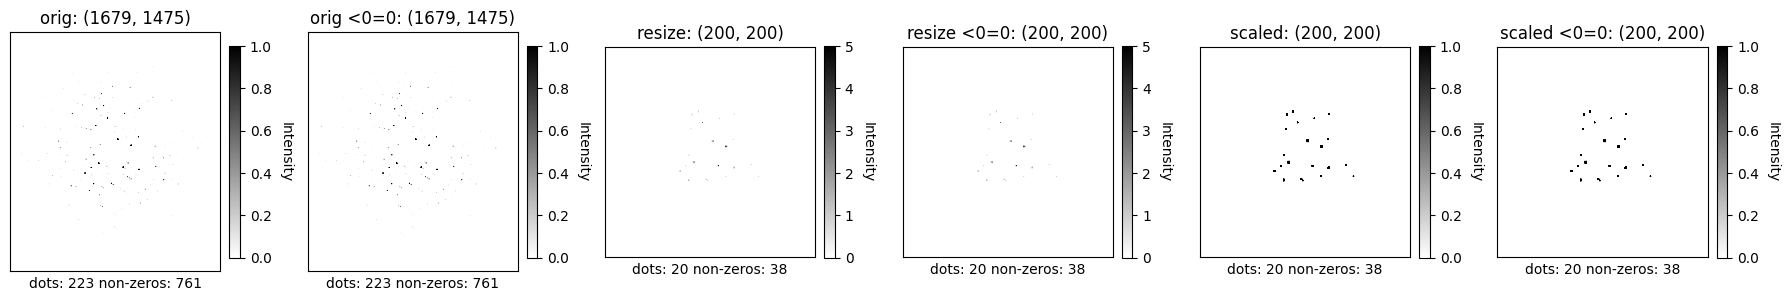

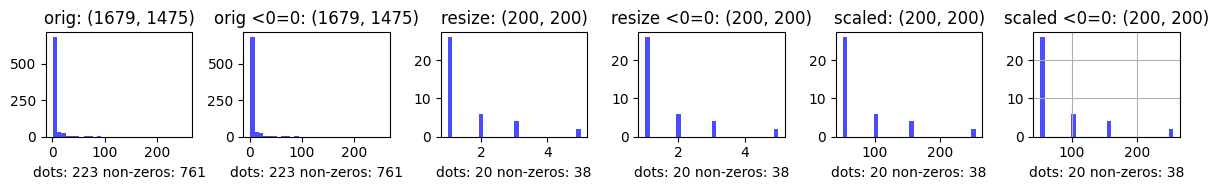

APPLY MAX INTENSITY VALUES OF 255...
max images_dots[2]: {'Mean': 255, 'Median': 255, 'Min': 255, '5th %': 255, '10th %': 255, '25th %': 255, '50th %': 255, '75th %': 255, '90th %': 255, '95th %': 255, 'Max': 255}
max small_images[2]: {'Mean': 255, 'Median': 255, 'Min': 255, '5th %': 255, '10th %': 255, '25th %': 255, '50th %': 255, '75th %': 255, '90th %': 255, '95th %': 255, 'Max': 255}
max small_images_scaled[2]: {'Mean': 255, 'Median': 255, 'Min': 255, '5th %': 255, '10th %': 255, '25th %': 255, '50th %': 255, '75th %': 255, '90th %': 255, '95th %': 255, 'Max': 255}


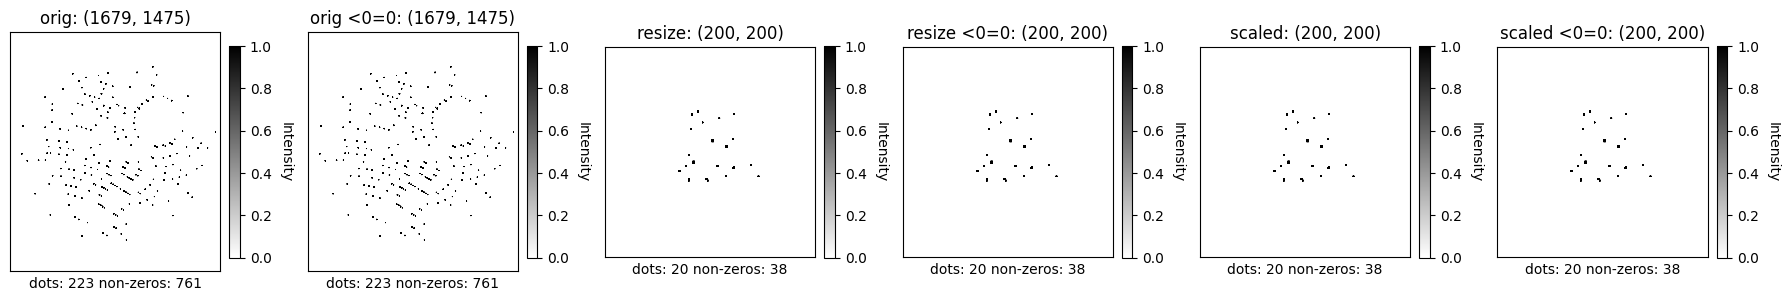

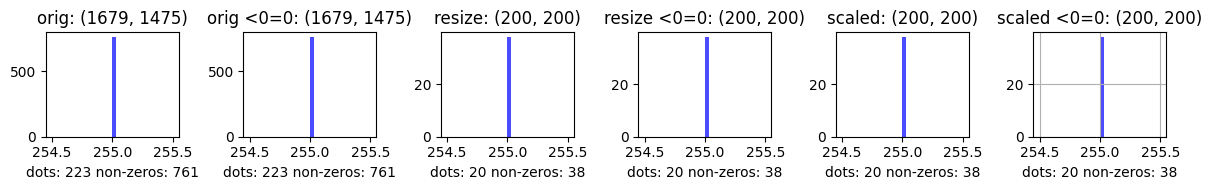

In [ ]:
# 0 (black) to 255 (white)
original_images = np.array(images_dots)
small_images = resizeImages(original_images)

# Fix the images approach 2: local min-max scaling (i.e. (i.e. current value = 57, local max value = 57, then (57-0)/(57-0)*255=255, current value = 5, then (5-0)/(57-0)*255=22))
small_images_scaled = np.array([img / np.max(img) * 255 if np.max(img) != 0 else img for img in small_images])

# plot two images for visualization, then plot another two images with noise removed for visualization
for i, (orig_img, resized_img, scaled_img) in enumerate(zip(images_dots, small_images, small_images_scaled)):
    if i == 2:
        print(f"images_dots[{i}]: {orig_img.shape}: {analyze_pixel_intensity(orig_img, 0)}")
        print(f"small_images[{i}]: {resized_img.shape}: {analyze_pixel_intensity(resized_img, 0)}")
        print(f"small_images_scaled[{i}]: {scaled_img.shape}: {analyze_pixel_intensity(scaled_img, 0)}")
        plot_image(orig_img, resized_img, scaled_img, 0)

        # Apply 3x3 components to remove noises
        # orig_img = remove_noise(orig_img, threshold=0)
        # resized_img = remove_noise(resized_img, threshold=0)
        # scaled_img = remove_noise(scaled_img, threshold=0)

        # print(f"noise removed images_dots[{i}]: {orig_img.shape} pixels: {analyze_pixel_intensity(orig_img, 0)}")
        # print(f"noise removed small_images[{i}]: {resized_img.shape} pixels: {analyze_pixel_intensity(resized_img, 0)}")
        # print(f"noise removed small_images_scaled[{i}]: {scaled_img.shape} pixels: {analyze_pixel_intensity(scaled_img, 0)}")
        # plot_image(orig_img, resized_img, scaled_img, 0)

# plot another two images by setting any pixels that are not zero to 255!!!
print(f"APPLY MAX INTENSITY VALUES OF 255...")
original_images[original_images > 0] = 255
small_images[small_images > 0] = 255
small_images_scaled[small_images_scaled > 0] = 255
for i, (orig_img, resized_img, scaled_img) in enumerate(zip(original_images, small_images, small_images_scaled)):
    if i == 2:
        print(f"max images_dots[{i}]: {analyze_pixel_intensity(orig_img, 0)}")
        print(f"max small_images[{i}]: {analyze_pixel_intensity(resized_img, 0)}")
        print(f"max small_images_scaled[{i}]: {analyze_pixel_intensity(scaled_img, 0)}")
        plot_image(orig_img, resized_img, scaled_img, 0)

# Print one row of image_dots[5] to see what's going on under the hood
# print('The first row of the image matrix contains',len(grayimg[100]),'pixels')
# print(grayimg[100])

# normal = small / 255.0 # Normalize the images, Not necessary, normalize just makes everything lower from 0-5 to 0-0.1.
# print(f"Normalized 200x200 images_dots summary - shape: {normal.shape} len: {len(normal)} image size: {normal[2].size} dot shape: {normal[2].shape}
# max: {np.max(normal[2])} min: {np.min(normal[2])} non-zeros: {np.count_nonzero(normal[2])}")

Analyzing images_dots statistics...
images_dots pixels: {'Mean': 6, 'Median': 2, 'Min': 1, '5th %': 1, '10th %': 1, '25th %': 1, '50th %': 2, '75th %': 5, '90th %': 13, '95th %': 24, 'Max': 255}
# images: 350 Mean number of dots: 261.27 Median: 261.0 Highest count: 447 Lowest count: 72
5th %: 147.80 10th: 180.00 25th: 214.00 50th: 261.00 75th: 305.25 90th: 357.10 95th: 380.55


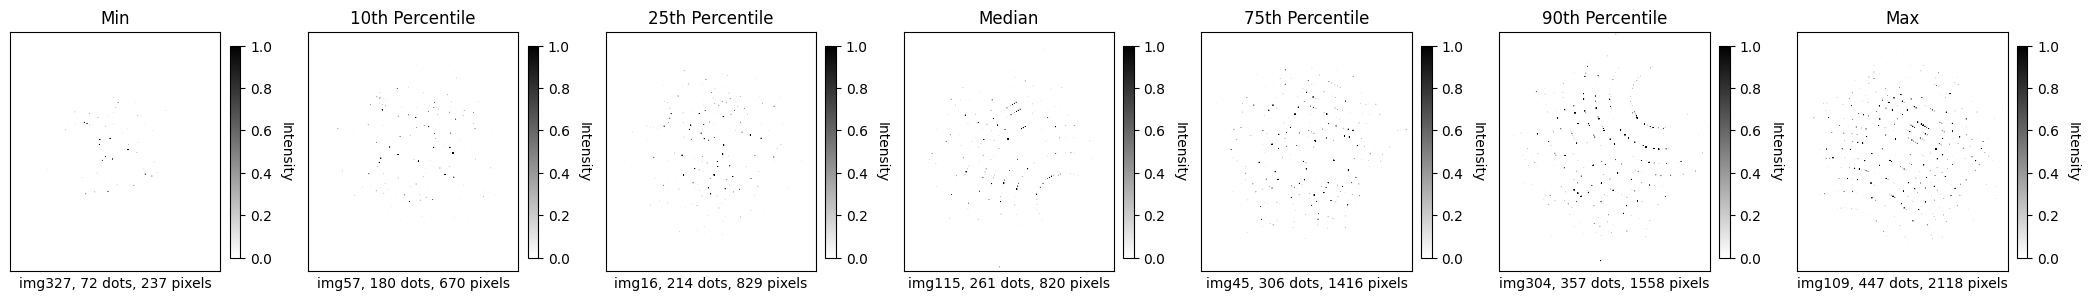

small_images dot pixels: {'Mean': 255, 'Median': 255, 'Min': 255, '5th %': 255, '10th %': 255, '25th %': 255, '50th %': 255, '75th %': 255, '90th %': 255, '95th %': 255, 'Max': 255}
# images: 350 Mean number of dots: 35.39 Median: 33.0 Highest count: 82 Lowest count: 2
5th %: 11.45 10th: 16.00 25th: 25.00 50th: 33.00 75th: 45.00 90th: 57.00 95th: 62.00


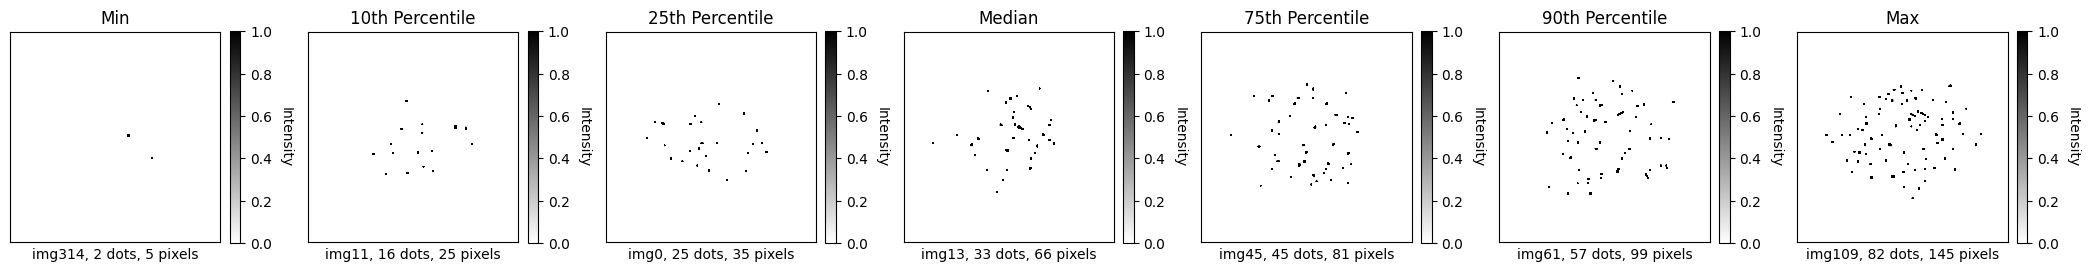

small_images_scaled dot pixels: {'Mean': 255, 'Median': 255, 'Min': 255, '5th %': 255, '10th %': 255, '25th %': 255, '50th %': 255, '75th %': 255, '90th %': 255, '95th %': 255, 'Max': 255}
# images: 350 Mean number of dots: 35.39 Median: 33.0 Highest count: 82 Lowest count: 2
5th %: 11.45 10th: 16.00 25th: 25.00 50th: 33.00 75th: 45.00 90th: 57.00 95th: 62.00


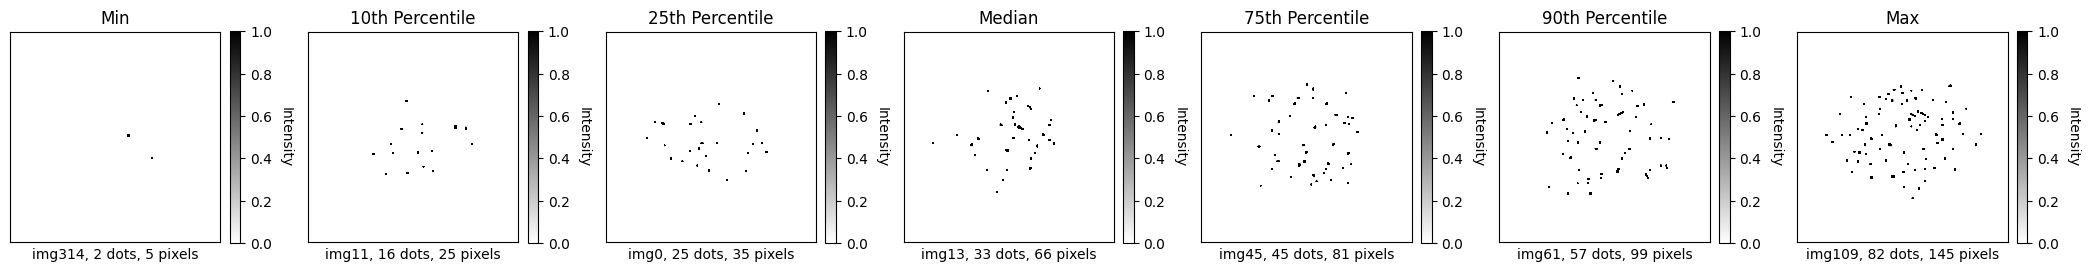

In [ ]:
# New analysis code to look at overall distribution in 700 images
print(f"Analyzing images_dots statistics...")

print(f"images_dots pixels: {analyze_pixel_intensity(images_dots, 0)}")
plot_dot_image_list_statistics(images_dots, 0)

print(f"small_images dot pixels: {analyze_pixel_intensity(small_images, 0)}")
plot_dot_image_list_statistics(small_images, 0)

print(f"small_images_scaled dot pixels: {analyze_pixel_intensity(small_images_scaled, 0)}")
plot_dot_image_list_statistics(small_images_scaled, 0)

images_rings[0]: (1679, 1475): {'Mean': 9, 'Median': 5, 'Min': 5, '5th %': 5, '10th %': 5, '25th %': 5, '50th %': 5, '75th %': 8, '90th %': 16, '95th %': 30, 'Max': 255}
small_images[0]: (200, 200): {'Mean': 10, 'Median': 6, 'Min': 5, '5th %': 5, '10th %': 5, '25th %': 5, '50th %': 6, '75th %': 11, '90th %': 23, '95th %': 31, 'Max': 57}
small_images_scaled[0]: (200, 200): {'Mean': 8, 'Median': 4, 'Min': 4, '5th %': 4, '10th %': 4, '25th %': 4, '50th %': 4, '75th %': 8, '90th %': 17, '95th %': 17, 'Max': 255}


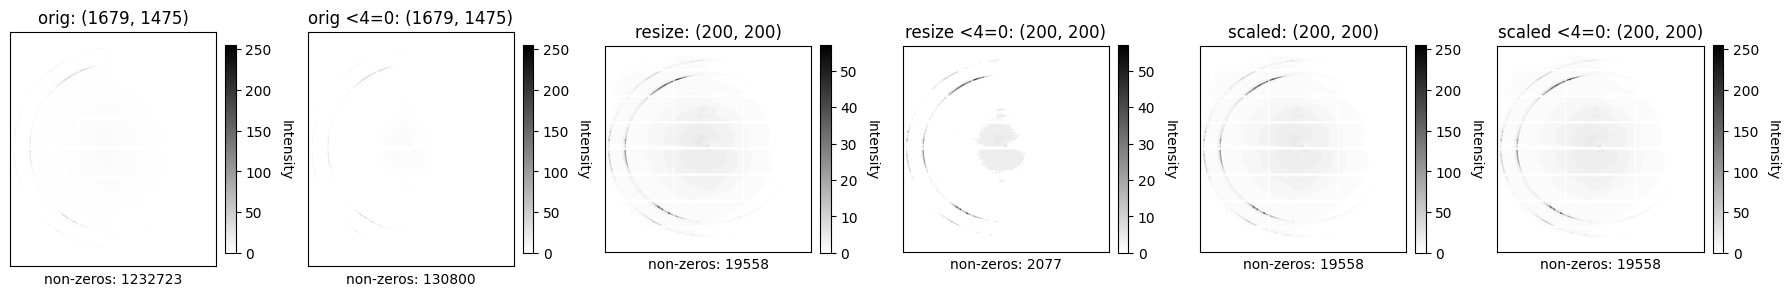

denoised images_rings[0]: (1679, 1475): {'Mean': 9, 'Median': 5, 'Min': 5, '5th %': 5, '10th %': 5, '25th %': 5, '50th %': 5, '75th %': 8, '90th %': 16, '95th %': 30, 'Max': 255}
denoised small_images[0]: (200, 200): {'Mean': 10, 'Median': 6, 'Min': 5, '5th %': 5, '10th %': 5, '25th %': 5, '50th %': 6, '75th %': 11, '90th %': 23, '95th %': 31, 'Max': 57}
denoised small_images_scaled[0]: (200, 200): {'Mean': 8, 'Median': 4, 'Min': 4, '5th %': 4, '10th %': 4, '25th %': 4, '50th %': 4, '75th %': 8, '90th %': 17, '95th %': 17, 'Max': 255}


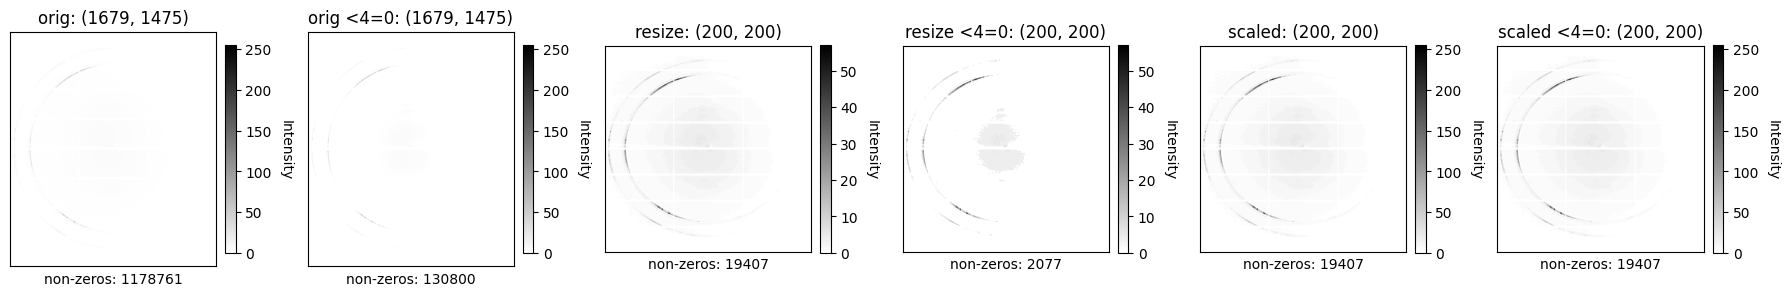

images_rings[1]: (1679, 1475): {'Mean': 13, 'Median': 8, 'Min': 5, '5th %': 5, '10th %': 5, '25th %': 6, '50th %': 8, '75th %': 15, '90th %': 28, '95th %': 39, 'Max': 255}
small_images[1]: (200, 200): {'Mean': 10, 'Median': 8, 'Min': 5, '5th %': 5, '10th %': 5, '25th %': 6, '50th %': 8, '75th %': 14, '90th %': 20, '95th %': 23, 'Max': 46}
small_images_scaled[1]: (200, 200): {'Mean': 8, 'Median': 5, 'Min': 5, '5th %': 5, '10th %': 5, '25th %': 5, '50th %': 5, '75th %': 11, '90th %': 11, '95th %': 16, 'Max': 255}


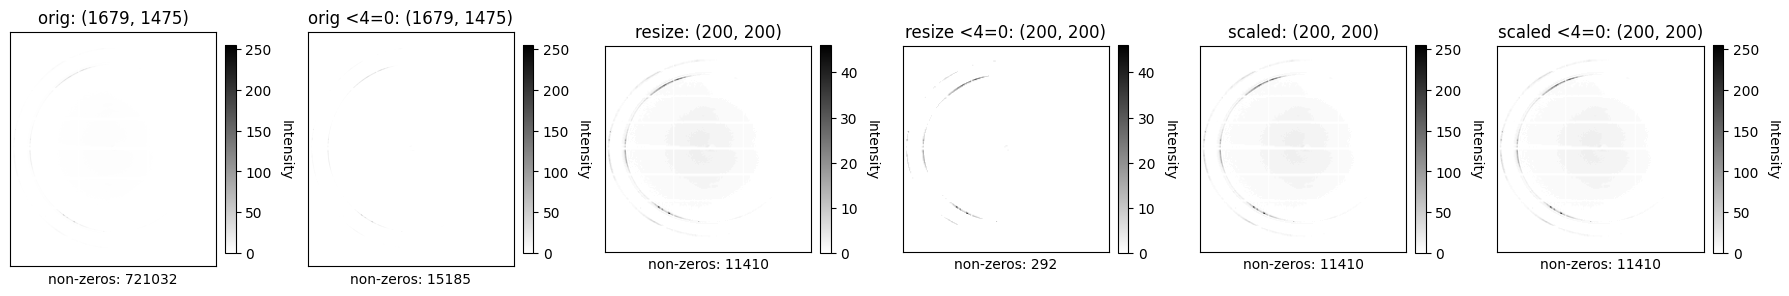

denoised images_rings[1]: (1679, 1475): {'Mean': 13, 'Median': 8, 'Min': 5, '5th %': 5, '10th %': 5, '25th %': 6, '50th %': 8, '75th %': 15, '90th %': 28, '95th %': 39, 'Max': 255}
denoised small_images[1]: (200, 200): {'Mean': 10, 'Median': 8, 'Min': 5, '5th %': 5, '10th %': 5, '25th %': 6, '50th %': 8, '75th %': 14, '90th %': 20, '95th %': 23, 'Max': 46}
denoised small_images_scaled[1]: (200, 200): {'Mean': 8, 'Median': 5, 'Min': 5, '5th %': 5, '10th %': 5, '25th %': 5, '50th %': 5, '75th %': 11, '90th %': 11, '95th %': 16, 'Max': 255}


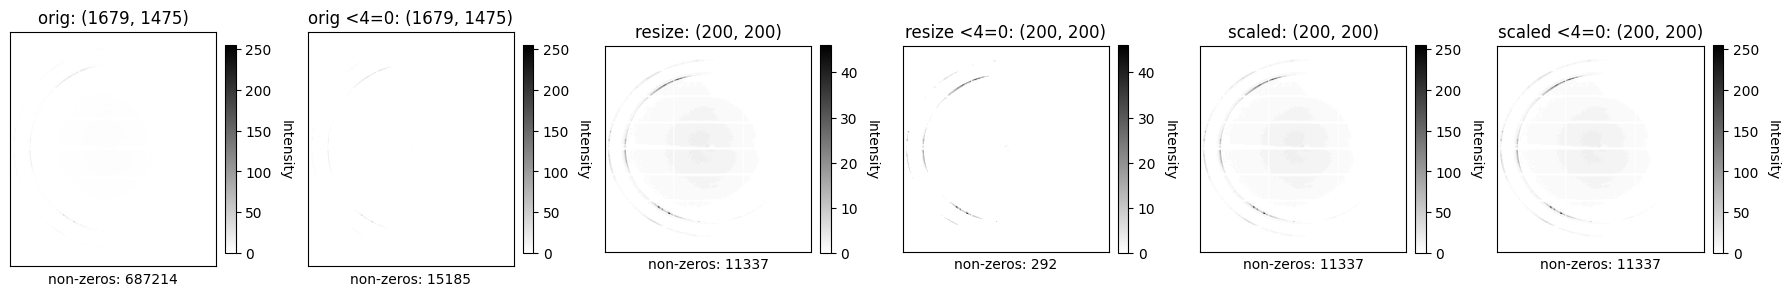

APPLY MAX INTENSITY VALUES OF 255...
max intensity images_rings[0]: (1679, 1475) pixels: {'Mean': 255, 'Median': 255, 'Min': 255, '5th %': 255, '10th %': 255, '25th %': 255, '50th %': 255, '75th %': 255, '90th %': 255, '95th %': 255, 'Max': 255}
max intensity small_images[0]: (200, 200) pixels: {'Mean': 255, 'Median': 255, 'Min': 255, '5th %': 255, '10th %': 255, '25th %': 255, '50th %': 255, '75th %': 255, '90th %': 255, '95th %': 255, 'Max': 255}
max intensity small_images_scaled[0]: (200, 200) pixels: {'Mean': 255, 'Median': 255, 'Min': 255, '5th %': 255, '10th %': 255, '25th %': 255, '50th %': 255, '75th %': 255, '90th %': 255, '95th %': 255, 'Max': 255}


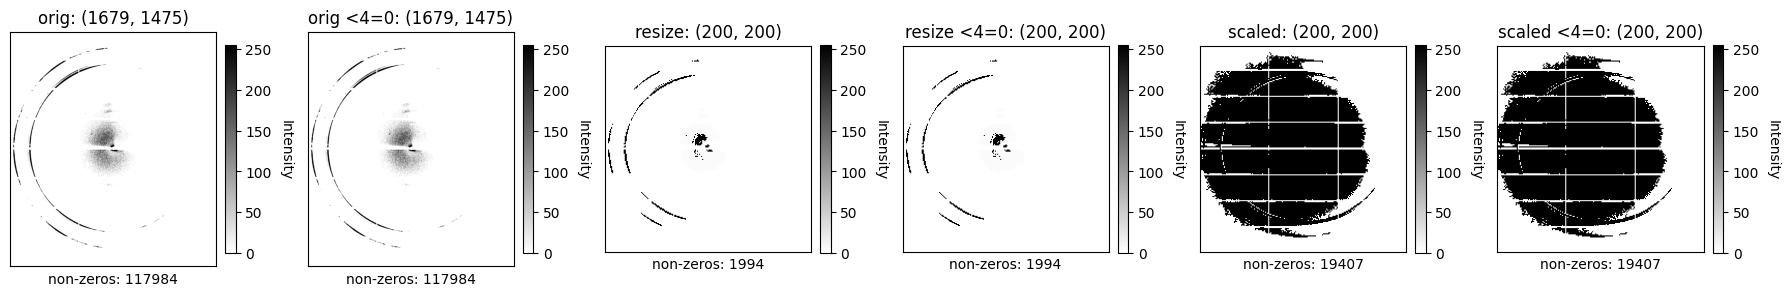

max intensity images_rings[1]: (1679, 1475) pixels: {'Mean': 255, 'Median': 255, 'Min': 255, '5th %': 255, '10th %': 255, '25th %': 255, '50th %': 255, '75th %': 255, '90th %': 255, '95th %': 255, 'Max': 255}
max intensity small_images[1]: (200, 200) pixels: {'Mean': 255, 'Median': 255, 'Min': 255, '5th %': 255, '10th %': 255, '25th %': 255, '50th %': 255, '75th %': 255, '90th %': 255, '95th %': 255, 'Max': 255}
max intensity small_images_scaled[1]: (200, 200) pixels: {'Mean': 255, 'Median': 255, 'Min': 255, '5th %': 255, '10th %': 255, '25th %': 255, '50th %': 255, '75th %': 255, '90th %': 255, '95th %': 255, 'Max': 255}


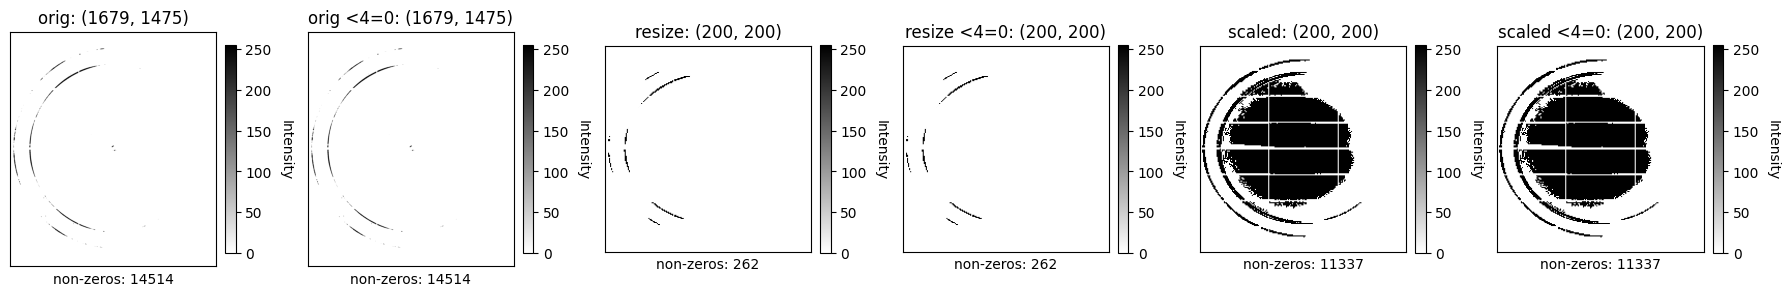

700 METAL RING SUMMARIES...
images_rings: {'Mean': 7, 'Median': 6, 'Min': 5, '5th %': 5, '10th %': 5, '25th %': 5, '50th %': 6, '75th %': 8, '90th %': 10, '95th %': 13, 'Max': 255}
small_images: {'Mean': 7, 'Median': 6, 'Min': 5, '5th %': 5, '10th %': 5, '25th %': 5, '50th %': 6, '75th %': 8, '90th %': 10, '95th %': 12, 'Max': 89}
small_images_scaled : {'Mean': 13, 'Median': 9, 'Min': 4, '5th %': 4, '10th %': 4, '25th %': 6, '50th %': 9, '75th %': 16, '90th %': 26, '95th %': 34, 'Max': 255}


In [ ]:
# 0 (black) to 255 (white)
original_images = np.array(images_rings)
small_images = resizeImages(original_images)
# Fix the images approach 1: global min-max normalization (i.e. current value = 57, global max value = 57, then (57-0)/(57-0)*255=255, current value = 5, then (5-0)/(57-0)*255=22)
# small_images = (small_images - np.min(small_images)) / (np.max(small_images) - np.min(small_images)) * 255
# Fix the images approach 2: local min-max scaling (i.e. (i.e. current value = 57, local max value = 57, then (57-0)/(57-0)*255=255, current value = 5, then (5-0)/(57-0)*255=22))
small_images_scaled = np.array([img / np.max(img) * 255 if np.max(img) != 0 else img for img in small_images])

# plot two images for visualization, then plot another two images with noise removed for visualization
for i, (orig_img, resized_img, scaled_img) in enumerate(zip(original_images, small_images, small_images_scaled)):
    if i < 2:
        print(f"images_rings[{i}]: {orig_img.shape}: {analyze_pixel_intensity(orig_img, 4)}")
        print(f"small_images[{i}]: {resized_img.shape}: {analyze_pixel_intensity(resized_img, 4)}")
        print(f"small_images_scaled[{i}]: {scaled_img.shape}: {analyze_pixel_intensity(scaled_img, 4)}")
        plot_image(orig_img, resized_img, scaled_img, 4, False, True)

        # Apply 3x3 components to remove noises
        orig_img = remove_noise(orig_img, threshold=0)
        resized_img = remove_noise(resized_img, threshold=0)
        scaled_img = remove_noise(scaled_img, threshold=0)

        print(f"denoised images_rings[{i}]: {orig_img.shape}: {analyze_pixel_intensity(orig_img, 4)}")
        print(f"denoised small_images[{i}]: {resized_img.shape}: {analyze_pixel_intensity(resized_img, 4)}")
        print(f"denoised small_images_scaled[{i}]: {scaled_img.shape}: {analyze_pixel_intensity(scaled_img, 4)}")
        plot_image(orig_img, resized_img, scaled_img, 4, False, True)

# plot another two images by setting any pixels that are not zero to 255!!!
print(f"APPLY MAX INTENSITY VALUES OF 255...")
for i, (orig_img, resized_img, scaled_img) in enumerate(zip(original_images, small_images, small_images_scaled)):
    if i < 2:
        # Apply 3x3 components plus threshold of 4 (any value that is <=4 and not not in 3x3 is reset to 0), tried 10 and 15, that removes most of the rings as well
        orig_img = remove_noise(orig_img, threshold=4)
        resized_img = remove_noise(resized_img, threshold=4)
        scaled_img = remove_noise(scaled_img, threshold=4)

        # Any remaining pixels that not zero is set to 255
        orig_img[orig_img>4]=255
        resized_img[resized_img>4]=255
        scaled_img[scaled_img>4]=255

        print(f"max intensity images_rings[{i}]: {orig_img.shape} pixels: {analyze_pixel_intensity(orig_img, 4)}")
        print(f"max intensity small_images[{i}]: {resized_img.shape} pixels: {analyze_pixel_intensity(resized_img, 4)}")
        print(f"max intensity small_images_scaled[{i}]: {scaled_img.shape} pixels: {analyze_pixel_intensity(scaled_img, 4)}")
        plot_image(orig_img, resized_img, scaled_img, 4, False, True)

# New analysis code to look at overall distribution in 700 images
print(f"700 METAL RING SUMMARIES...")
print(f"images_rings: {analyze_pixel_intensity(original_images, 4)}")
print(f"small_images: {analyze_pixel_intensity(small_images, 4)}")
print(f"small_images_scaled : {analyze_pixel_intensity(small_images_scaled, 4)}")

# Print one row of image_rings[0] to see what's going on under the hood
# https://www.kaggle.com/code/akshayt19nayak/getting-started-image-processing-basics/notebook
# print('The first row of the image matrix contains',len(grayimg[100]),'pixels')
# print(grayimg[100])

images_rings2[0]: (1679, 1475): {'Mean': 3, 'Median': 1, 'Min': 1, '5th %': 1, '10th %': 1, '25th %': 1, '50th %': 1, '75th %': 3, '90th %': 6, '95th %': 11, 'Max': 255}
small_images2[0]: (200, 200): {'Mean': 1, 'Median': 1, 'Min': 1, '5th %': 1, '10th %': 1, '25th %': 1, '50th %': 1, '75th %': 2, '90th %': 3, '95th %': 4, 'Max': 10}
small_images2_scaled[0]: (200, 200): {'Mean': 44, 'Median': 25, 'Min': 25, '5th %': 25, '10th %': 25, '25th %': 25, '50th %': 25, '75th %': 51, '90th %': 76, '95th %': 102, 'Max': 255}


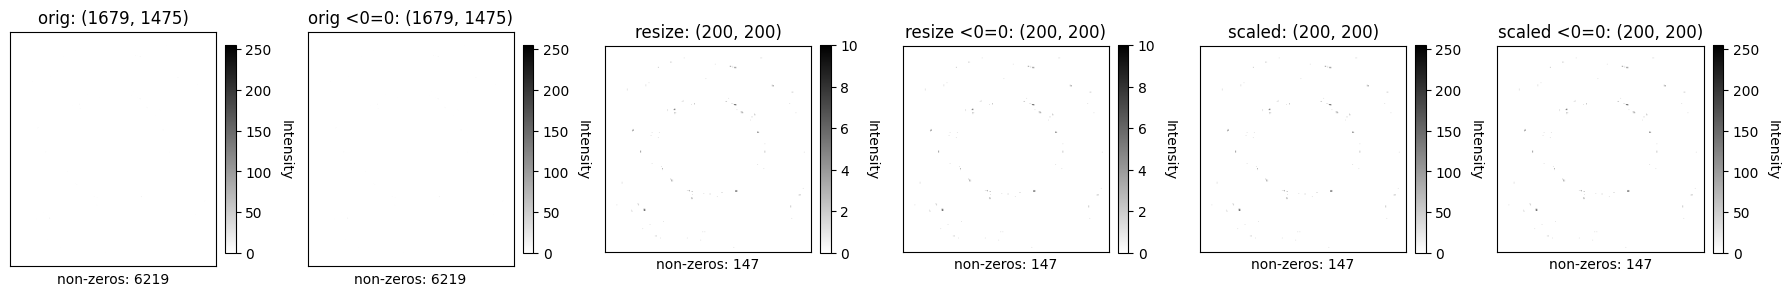

images_rings2[1]: (1679, 1475): {'Mean': 3, 'Median': 1, 'Min': 1, '5th %': 1, '10th %': 1, '25th %': 1, '50th %': 1, '75th %': 3, '90th %': 7, '95th %': 12, 'Max': 255}
small_images2[1]: (200, 200): {'Mean': 1, 'Median': 1, 'Min': 1, '5th %': 1, '10th %': 1, '25th %': 1, '50th %': 1, '75th %': 2, '90th %': 2, '95th %': 3, 'Max': 11}
small_images2_scaled[1]: (200, 200): {'Mean': 35, 'Median': 23, 'Min': 23, '5th %': 23, '10th %': 23, '25th %': 23, '50th %': 23, '75th %': 46, '90th %': 46, '95th %': 69, 'Max': 255}


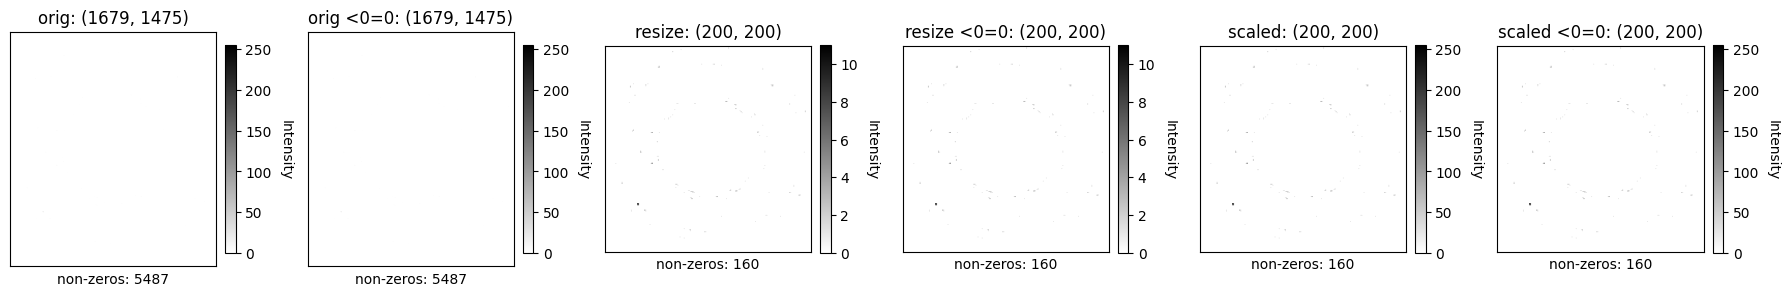

APPLY MAX INTENSITY VALUES OF 255...
max images_rings2[0]: (1679, 1475): {'Mean': 255, 'Median': 255, 'Min': 255, '5th %': 255, '10th %': 255, '25th %': 255, '50th %': 255, '75th %': 255, '90th %': 255, '95th %': 255, 'Max': 255}
max small_images2[0]: (200, 200): {'Mean': 255, 'Median': 255, 'Min': 255, '5th %': 255, '10th %': 255, '25th %': 255, '50th %': 255, '75th %': 255, '90th %': 255, '95th %': 255, 'Max': 255}
max small_images2_scaled[0]: (200, 200): {'Mean': 255, 'Median': 255, 'Min': 255, '5th %': 255, '10th %': 255, '25th %': 255, '50th %': 255, '75th %': 255, '90th %': 255, '95th %': 255, 'Max': 255}


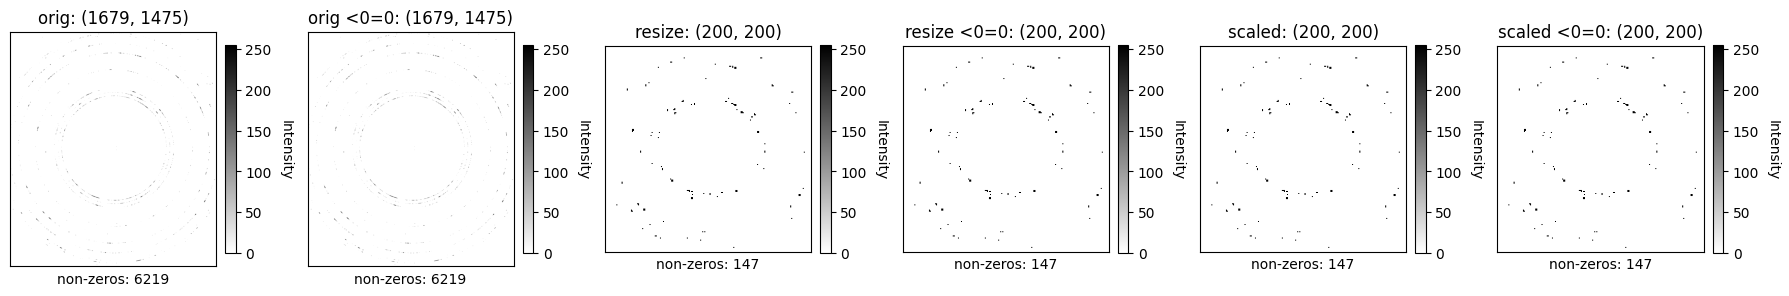

max images_rings2[1]: (1679, 1475): {'Mean': 255, 'Median': 255, 'Min': 255, '5th %': 255, '10th %': 255, '25th %': 255, '50th %': 255, '75th %': 255, '90th %': 255, '95th %': 255, 'Max': 255}
max small_images2[1]: (200, 200): {'Mean': 255, 'Median': 255, 'Min': 255, '5th %': 255, '10th %': 255, '25th %': 255, '50th %': 255, '75th %': 255, '90th %': 255, '95th %': 255, 'Max': 255}
max small_images2_scaled[1]: (200, 200): {'Mean': 255, 'Median': 255, 'Min': 255, '5th %': 255, '10th %': 255, '25th %': 255, '50th %': 255, '75th %': 255, '90th %': 255, '95th %': 255, 'Max': 255}


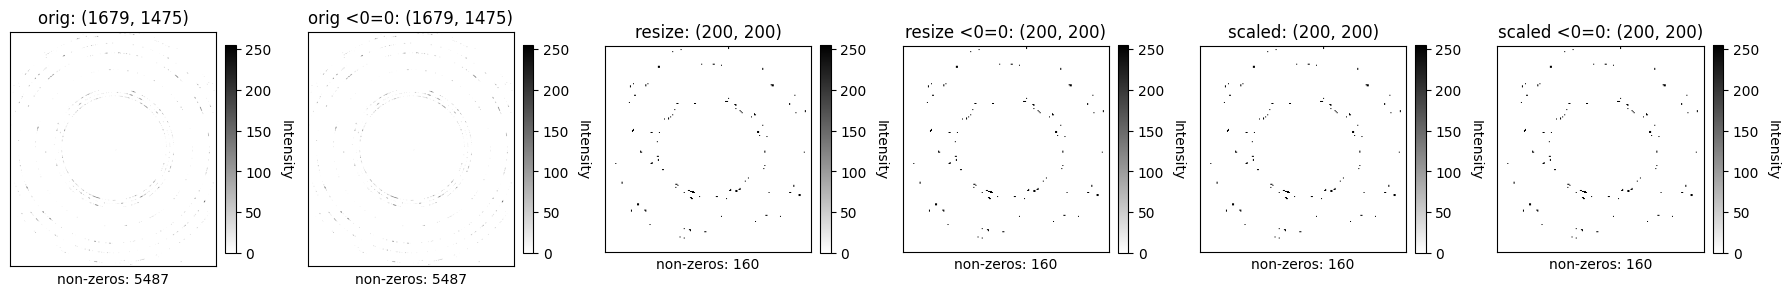

700 ICE RING IMAGE SUMMARIES...
images_rings2: {'Mean': 255, 'Median': 255, 'Min': 255, '5th %': 255, '10th %': 255, '25th %': 255, '50th %': 255, '75th %': 255, '90th %': 255, '95th %': 255, 'Max': 255}
small_images2: {'Mean': 255, 'Median': 255, 'Min': 255, '5th %': 255, '10th %': 255, '25th %': 255, '50th %': 255, '75th %': 255, '90th %': 255, '95th %': 255, 'Max': 255}
small_images2_scaled: {'Mean': 255, 'Median': 255, 'Min': 255, '5th %': 255, '10th %': 255, '25th %': 255, '50th %': 255, '75th %': 255, '90th %': 255, '95th %': 255, 'Max': 255}


In [ ]:
# 0 (black) to 255 (white)
original_images2 = np.array(images_rings2)
small_images2 = resizeImages(original_images2)
# Fix the images approach 1: global min-max normalization (i.e. current value = 5, global max value = 57, then (5-0)/(57-0)*255=22)
# small_images2 = (small_images2 - np.min(small_images2)) / (np.max(small_images2) - np.min(small_images2)) * 255
# Fix the images approach 2: local min-max scaling (i.e. (i.e. current value = 5, local max value = 10, then (5-0)/(10-0)*255=128))
small_images2_scaled = np.array([img / np.max(img) * 255 if np.max(img) != 0 else img for img in small_images2])

# plot two images for visualization
for i, (orig_img2, resized_img2, scaled_img2) in enumerate(zip(original_images2, small_images2, small_images2_scaled)):
    if i < 2:
        print(f"images_rings2[{i}]: {orig_img2.shape}: {analyze_pixel_intensity(orig_img2, 0)}")
        print(f"small_images2[{i}]: {resized_img2.shape}: {analyze_pixel_intensity(resized_img2, 0)}")
        print(f"small_images2_scaled[{i}]: {scaled_img2.shape}: {analyze_pixel_intensity(scaled_img2, 0)}")
        plot_image(orig_img2, resized_img2, scaled_img2, 0, False, True)

# plot another two images by setting any pixels that are not zero to 255!!!
print(f"APPLY MAX INTENSITY VALUES OF 255...")
original_images2[original_images2 > 0] = 255
small_images2[small_images2 > 0] = 255
small_images2_scaled[small_images2_scaled > 0] = 255
for i, (orig_img2, resized_img2, scaled_img2) in enumerate(zip(original_images2, small_images2, small_images2_scaled)):
    if i < 2:
        print(f"max images_rings2[{i}]: {orig_img2.shape}: {analyze_pixel_intensity(orig_img2, 0)}")
        print(f"max small_images2[{i}]: {resized_img2.shape}: {analyze_pixel_intensity(resized_img2, 0)}")
        print(f"max small_images2_scaled[{i}]: {scaled_img2.shape}: {analyze_pixel_intensity(scaled_img2, 0)}")
        plot_image(orig_img2, resized_img2, scaled_img2, 0, False, True)

# New analysis code to look at overall distribution in 700 images
print(f"700 ICE RING IMAGE SUMMARIES...")
print(f"images_rings2: {analyze_pixel_intensity(original_images2, 0)}")
print(f"small_images2: {analyze_pixel_intensity(small_images2, 0)}")
print(f"small_images2_scaled: {analyze_pixel_intensity(small_images2_scaled, 0)}")

Analyzing images_rings statistics - Based on number of pixels rather than number of rings, but should infer number of rings
# images: 350 Mean number of dots: 5291.35 Median: 4896.5 Highest count: 25692 Lowest count: 5


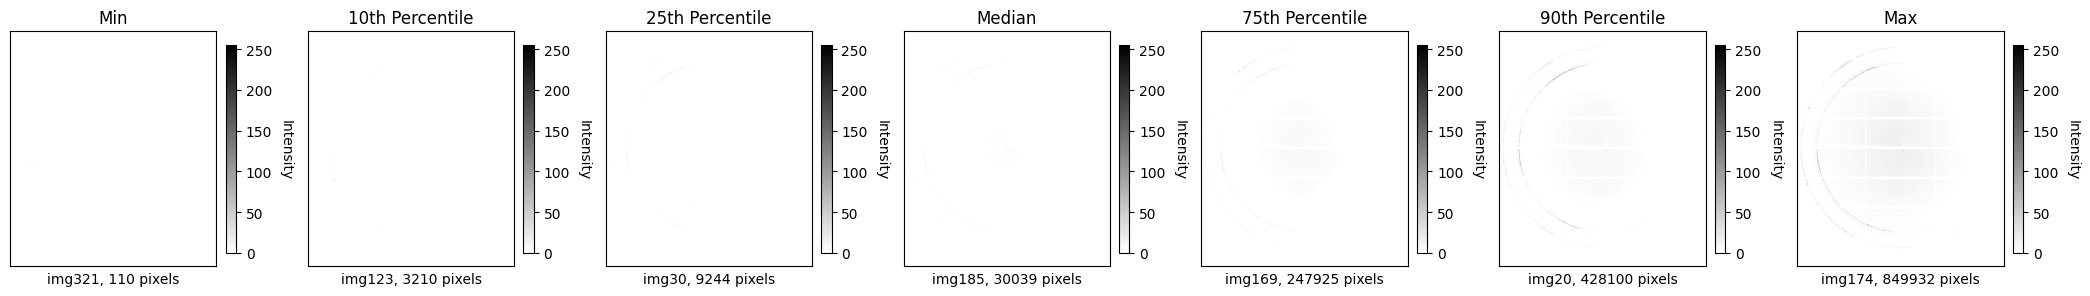

# images: 350 Mean number of dots: 36.15 Median: 40.0 Highest count: 82 Lowest count: 1


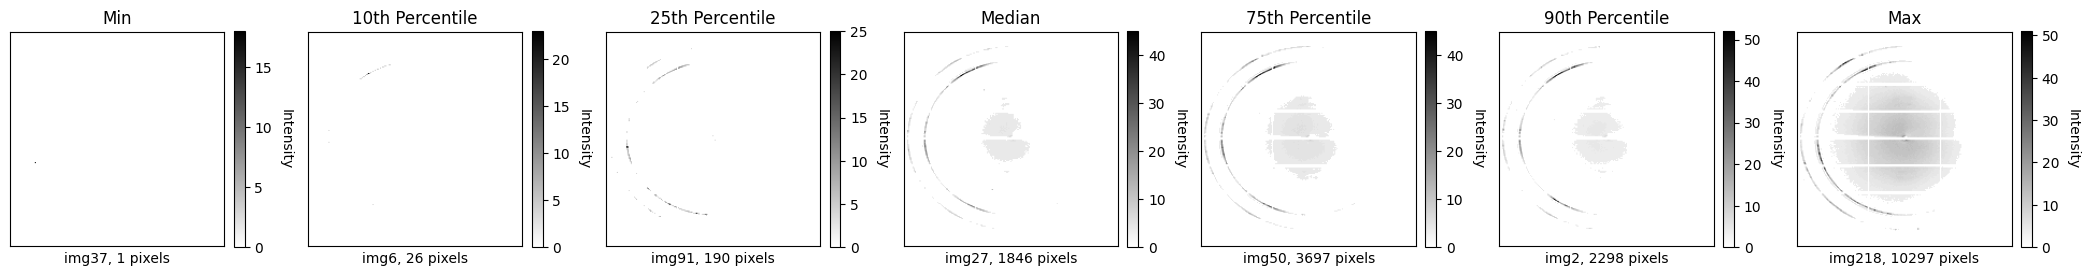

# images: 350 Mean number of dots: 68.63 Median: 64.5 Highest count: 166 Lowest count: 4


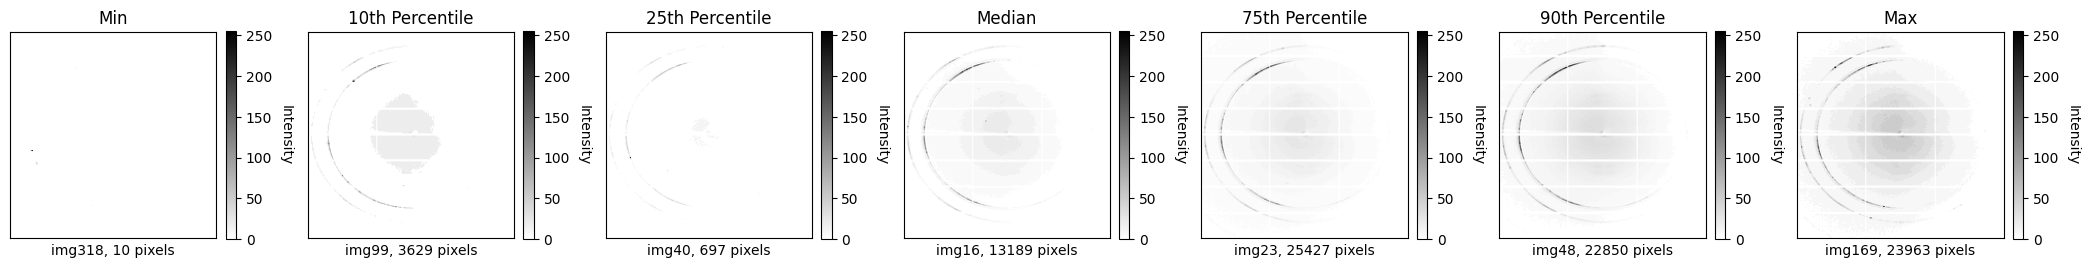

In [ ]:
print(f"Analyzing images_rings statistics - Based on number of pixels rather than number of rings, but should infer number of rings")
plot_dot_image_list_statistics(original_images, 4, False, True)
plot_dot_image_list_statistics(small_images, 4, False, True)
plot_dot_image_list_statistics(small_images_scaled, 4, False, True) # did not scale all non-zeros to 255

Analyzing images_rings2 statistics - Based on number of pixels rather than number of rings, but should infer number of rings
# images: 350 Mean number of dots: 8818.75 Median: 1517.0 Highest count: 37317 Lowest count: 268


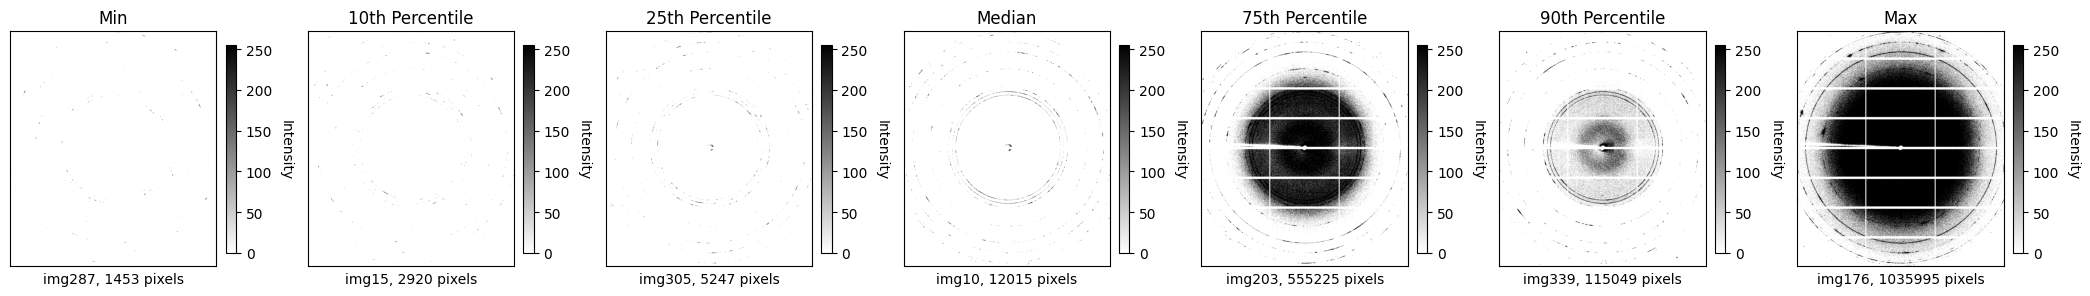

# images: 350 Mean number of dots: 110.43 Median: 104.0 Highest count: 235 Lowest count: 15


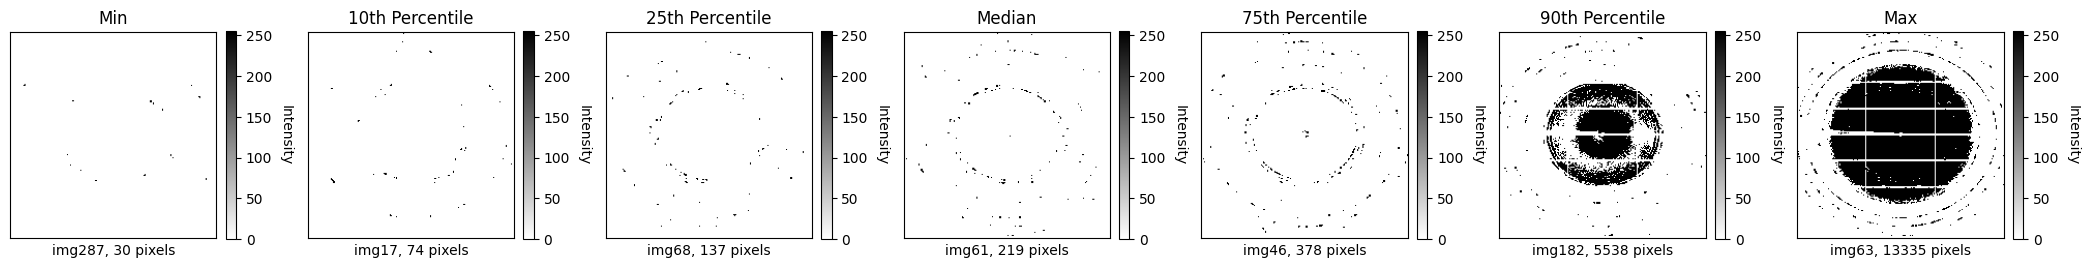

# images: 350 Mean number of dots: 110.43 Median: 104.0 Highest count: 235 Lowest count: 15


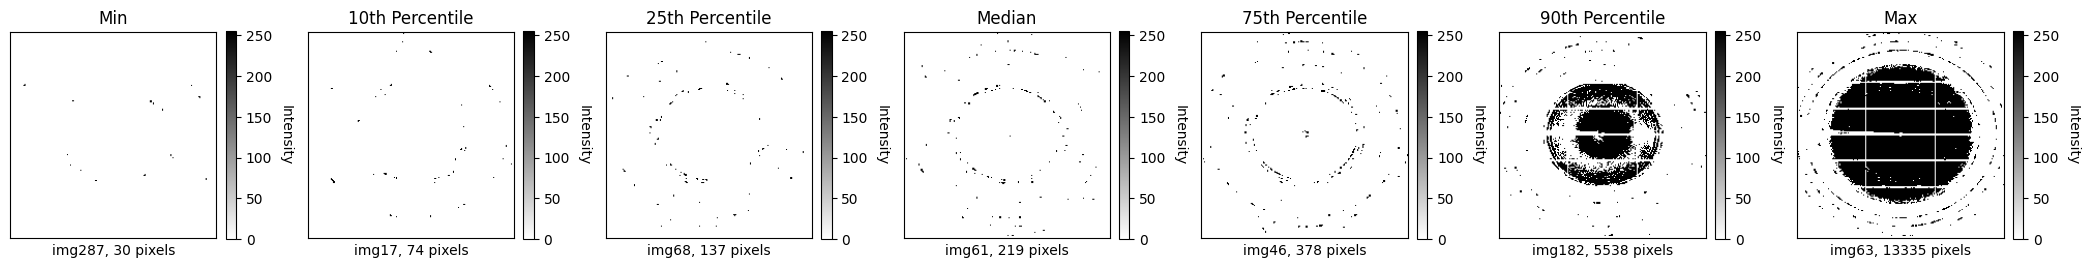

In [ ]:
print(f"Analyzing images_rings2 statistics - Based on number of pixels rather than number of rings, but should infer number of rings")
plot_dot_image_list_statistics(original_images2, 0, False, True)
plot_dot_image_list_statistics(small_images2, 0, False, True)
plot_dot_image_list_statistics(small_images2_scaled, 0, False, True)

Conclusions

Pixel intensity values low
Number of dots in resized image is less
The background in rings are confusing


images_blank[0]: (1679, 1475): {'Mean': 6, 'Median': 5, 'Min': 1, '5th %': 1, '10th %': 3, '25th %': 3, '50th %': 5, '75th %': 8, '90th %': 14, '95th %': 16, 'Max': 255}
small_images[0]: (200, 200): {'Mean': 6, 'Median': 5, 'Min': 1, '5th %': 3, '10th %': 4, '25th %': 5, '50th %': 5, '75th %': 8, '90th %': 13, '95th %': 15, 'Max': 84}
small_images_scaled[0]: (200, 200): {'Mean': 20, 'Median': 15, 'Min': 3, '5th %': 9, '10th %': 12, '25th %': 15, '50th %': 15, '75th %': 24, '90th %': 39, '95th %': 45, 'Max': 255}


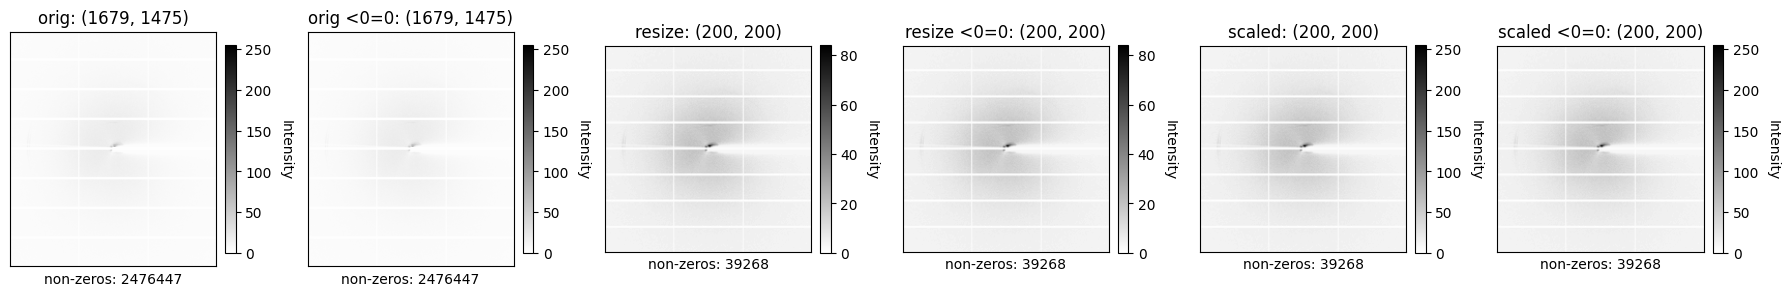

denoised images_blank[0]: (1679, 1475): {'Mean': 6, 'Median': 5, 'Min': 1, '5th %': 1, '10th %': 3, '25th %': 3, '50th %': 5, '75th %': 8, '90th %': 14, '95th %': 16, 'Max': 255}
denoised small_images[0]: (200, 200): {'Mean': 6, 'Median': 5, 'Min': 1, '5th %': 3, '10th %': 4, '25th %': 5, '50th %': 5, '75th %': 8, '90th %': 13, '95th %': 15, 'Max': 84}
denoised small_images_scaled[0]: (200, 200): {'Mean': 20, 'Median': 15, 'Min': 3, '5th %': 9, '10th %': 12, '25th %': 15, '50th %': 15, '75th %': 24, '90th %': 39, '95th %': 45, 'Max': 255}


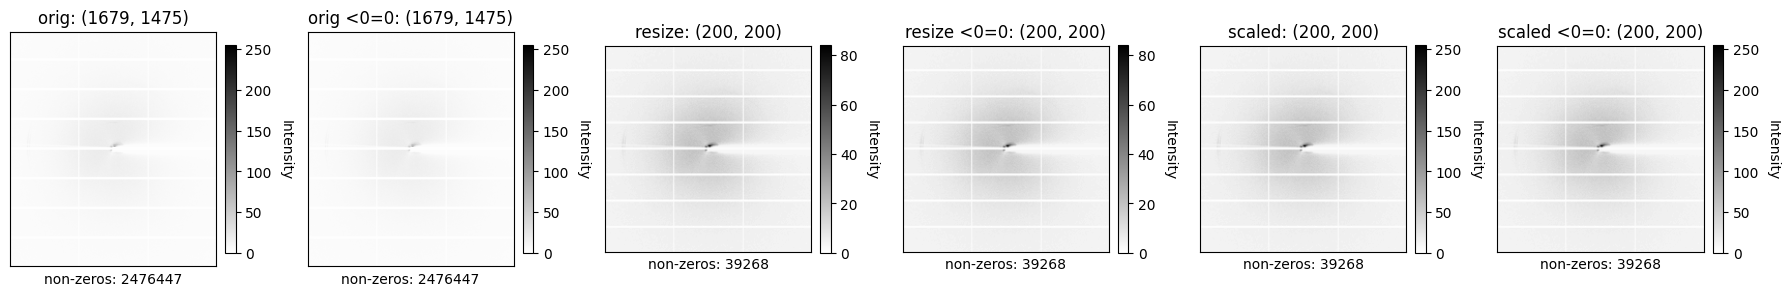

images_blank[1]: (1679, 1475): {'Mean': 6, 'Median': 5, 'Min': 1, '5th %': 1, '10th %': 3, '25th %': 3, '50th %': 5, '75th %': 8, '90th %': 13, '95th %': 17, 'Max': 255}
small_images[1]: (200, 200): {'Mean': 6, 'Median': 5, 'Min': 1, '5th %': 3, '10th %': 4, '25th %': 4, '50th %': 5, '75th %': 8, '90th %': 12, '95th %': 15, 'Max': 82}
small_images_scaled[1]: (200, 200): {'Mean': 20, 'Median': 15, 'Min': 3, '5th %': 9, '10th %': 12, '25th %': 12, '50th %': 15, '75th %': 24, '90th %': 37, '95th %': 46, 'Max': 255}


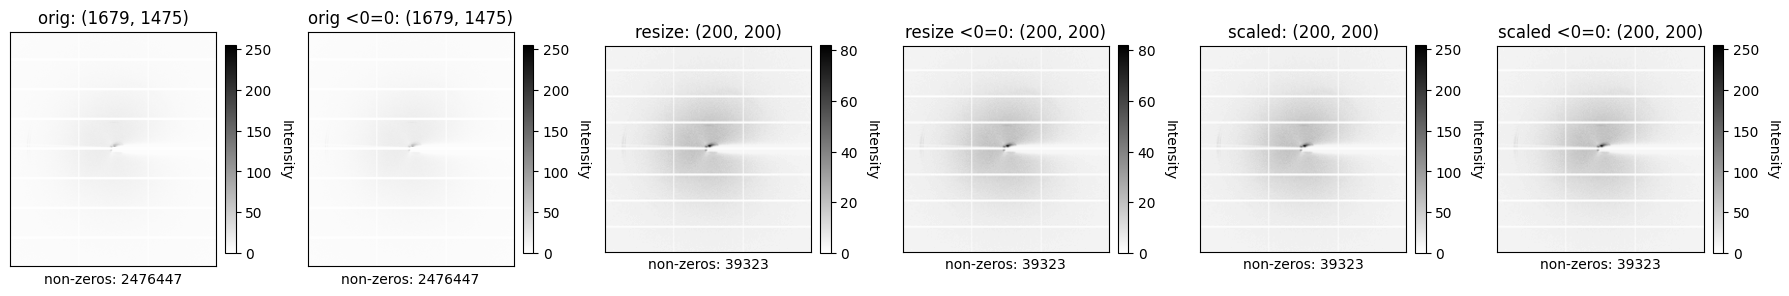

denoised images_blank[1]: (1679, 1475): {'Mean': 6, 'Median': 5, 'Min': 1, '5th %': 1, '10th %': 3, '25th %': 3, '50th %': 5, '75th %': 8, '90th %': 13, '95th %': 17, 'Max': 255}
denoised small_images[1]: (200, 200): {'Mean': 6, 'Median': 5, 'Min': 1, '5th %': 3, '10th %': 4, '25th %': 4, '50th %': 5, '75th %': 8, '90th %': 12, '95th %': 15, 'Max': 82}
denoised small_images_scaled[1]: (200, 200): {'Mean': 20, 'Median': 15, 'Min': 3, '5th %': 9, '10th %': 12, '25th %': 12, '50th %': 15, '75th %': 24, '90th %': 37, '95th %': 46, 'Max': 255}


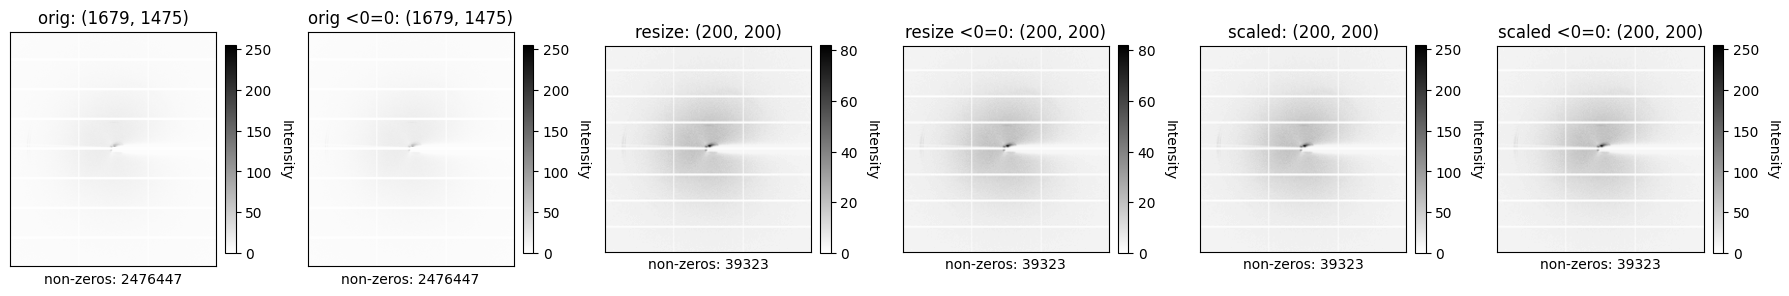

images_blank: {'Mean': 8, 'Median': 6, 'Min': 1, '5th %': 1, '10th %': 2, '25th %': 3, '50th %': 6, '75th %': 10, '90th %': 17, '95th %': 23, 'Max': 255}
small_images: {'Mean': 8, 'Median': 6, 'Min': 1, '5th %': 2, '10th %': 3, '25th %': 4, '50th %': 6, '75th %': 11, '90th %': 16, '95th %': 21, 'Max': 133}
small_images_scaled: {'Mean': 19, 'Median': 13, 'Min': 1, '5th %': 5, '10th %': 6, '25th %': 8, '50th %': 13, '75th %': 24, '90th %': 37, '95th %': 49, 'Max': 255}


In [ ]:
#Archive code for blank images (VISUALIZE IT FOR BETTER UNDERSTANDING)
# 0 (black) to 255 (white)
original_images = np.array(images_blank)
small_images = resizeImages(original_images)
# Fix the images: local min-max scaling (i.e. (i.e. current value = 57, local max value = 57, then (57-0)/(57-0)*255=255, current value = 5, then (5-0)/(57-0)*255=22))
small_images_scaled = np.array([img / np.max(img) * 255 if np.max(img) != 0 else img for img in small_images])

# plot two images for visualization, then plot another two images with noise removed for visualization
for i, (orig_img, resized_img, scaled_img) in enumerate(zip(original_images, small_images, small_images_scaled)):
    if i < 2:
        print(f"images_blank[{i}]: {orig_img.shape}: {analyze_pixel_intensity(orig_img, 0)}")
        print(f"small_images[{i}]: {resized_img.shape}: {analyze_pixel_intensity(resized_img, 0)}")
        print(f"small_images_scaled[{i}]: {scaled_img.shape}: {analyze_pixel_intensity(scaled_img, 0)}")
        plot_image(orig_img, resized_img, scaled_img, 0, False, True)

        # Apply 3x3 components to remove noises
        orig_img = remove_noise(orig_img, threshold=0)
        resized_img = remove_noise(resized_img, threshold=0)
        scaled_img = remove_noise(scaled_img, threshold=0)

        print(f"denoised images_blank[{i}]: {orig_img.shape}: {analyze_pixel_intensity(orig_img, 0)}")
        print(f"denoised small_images[{i}]: {resized_img.shape}: {analyze_pixel_intensity(resized_img, 0)}")
        print(f"denoised small_images_scaled[{i}]: {scaled_img.shape}: {analyze_pixel_intensity(scaled_img, 0)}")
        plot_image(orig_img, resized_img, scaled_img, 0, False, True)

# plot another two images by setting any pixels that are not zero to 255!!!
# for i, (orig_img, resized_img, scaled_img) in enumerate(zip(original_images, small_images, small_images_scaled)):
#    if i < 2:
#        # Apply 3x3 components plus threshold of 4 (any value that is <=4 and not not in 3x3 is reset to 0)
#        orig_img = remove_noise(orig_img, threshold=4)
#        resized_img = remove_noise(resized_img, threshold=4)
#        scaled_img = remove_noise(scaled_img, threshold=4)
#
#        # Any remaining pixels that not zero is set to 255
#        orig_img[orig_img>0]=255
#        resized_img[resized_img>0]=255
#        scaled_img[scaled_img>0]=255
#
#        print(f"max images_rings[{i}]: {orig_img.shape}: {analyze_pixel_intensity(orig_img, 4)}")
#        print(f"max small_images[{i}]: {resized_img.shape}: {analyze_pixel_intensity(resized_img, 4)}")
#        print(f"max small_images_scaled[{i}]: {scaled_img.shape}: {analyze_pixel_intensity(scaled_img, 4)}")
#        plot_image(orig_img, resized_img, scaled_img, 4, False, True)

# New analysis code to look at overall distribution in 700 images
print(f"images_blank: {analyze_pixel_intensity(original_images, 0)}")
print(f"small_images: {analyze_pixel_intensity(small_images, 0)}")
print(f"small_images_scaled: {analyze_pixel_intensity(small_images_scaled, 0)}")

Analyzing images_blank statistics - Based on number of pixels rather than number of rings, but should infer number of rings
# images: 350 Mean number of dots: 1.00 Median: 1.0 Highest count: 1 Lowest count: 1


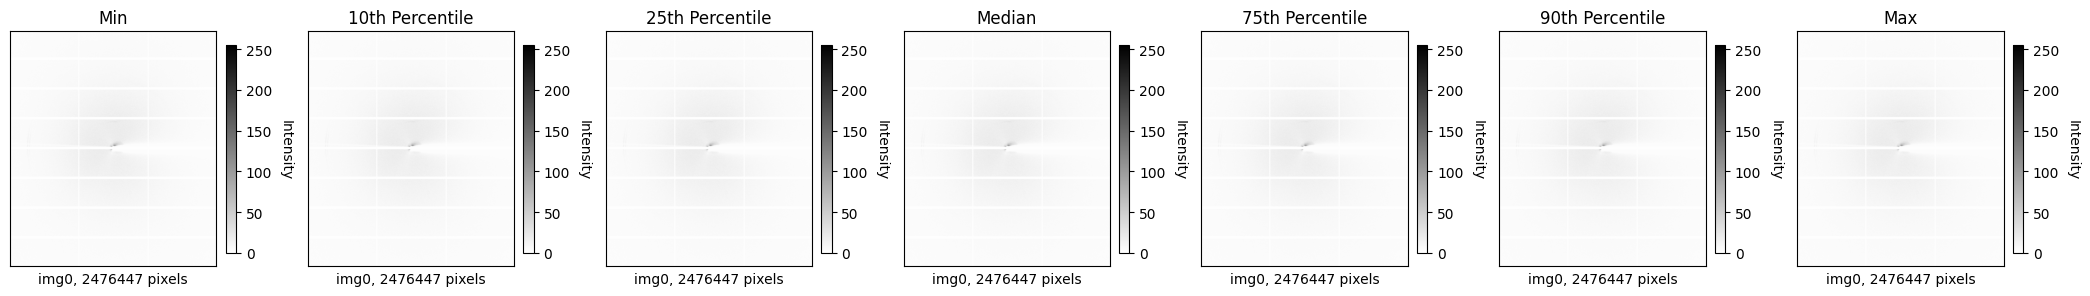

# images: 350 Mean number of dots: 1.00 Median: 1.0 Highest count: 1 Lowest count: 1


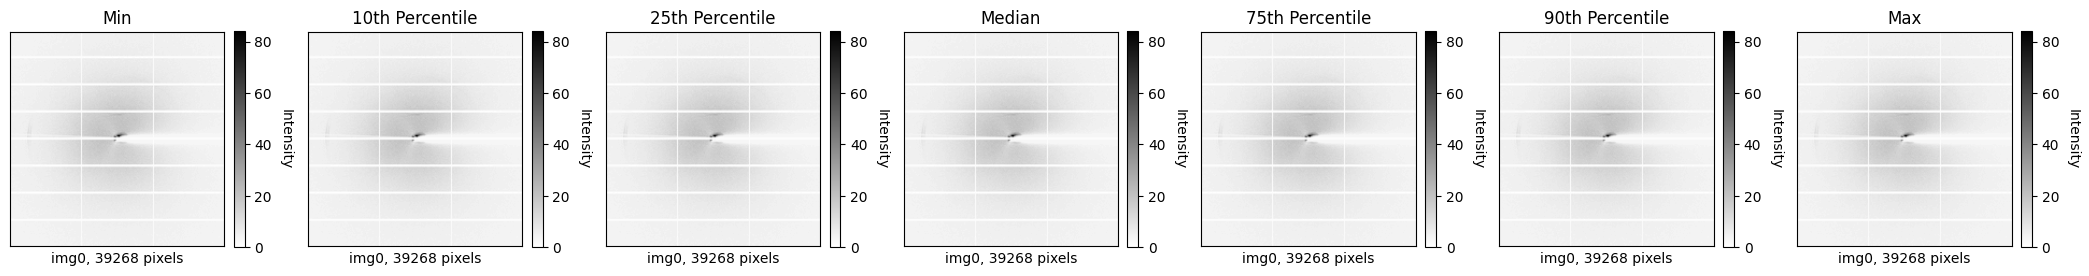

# images: 350 Mean number of dots: 1.00 Median: 1.0 Highest count: 1 Lowest count: 1


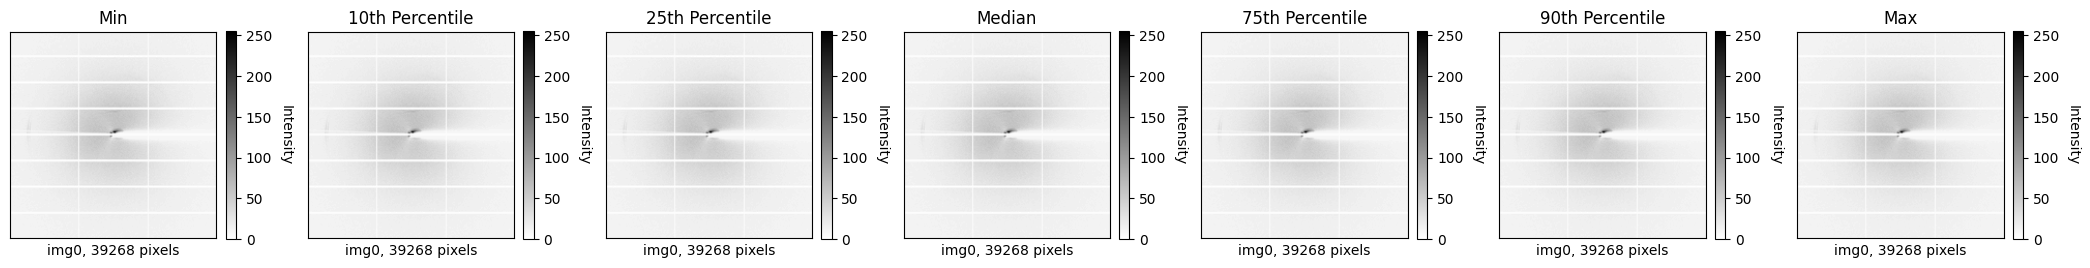

In [ ]:
print(f"Analyzing images_blank statistics - Based on number of pixels rather than number of rings, but should infer number of rings")
plot_dot_image_list_statistics(original_images, 0, False, True)
plot_dot_image_list_statistics(small_images, 0, False, True)
plot_dot_image_list_statistics(small_images_scaled, 0, False, True) # did not scale all non-zeros to 255

images_cleaned[0]: (1679, 1475): {'Mean': 8, 'Median': 4, 'Min': 1, '5th %': 1, '10th %': 2, '25th %': 2, '50th %': 4, '75th %': 7, '90th %': 11, '95th %': 14, 'Max': 255}
small_images[0]: (200, 200): {'Mean': 8, 'Median': 4, 'Min': 1, '5th %': 2, '10th %': 3, '25th %': 3, '50th %': 4, '75th %': 7, '90th %': 11, '95th %': 14, 'Max': 251}
small_images_scaled[0]: (200, 200): {'Mean': 8, 'Median': 4, 'Min': 1, '5th %': 2, '10th %': 3, '25th %': 3, '50th %': 4, '75th %': 7, '90th %': 11, '95th %': 14, 'Max': 255}


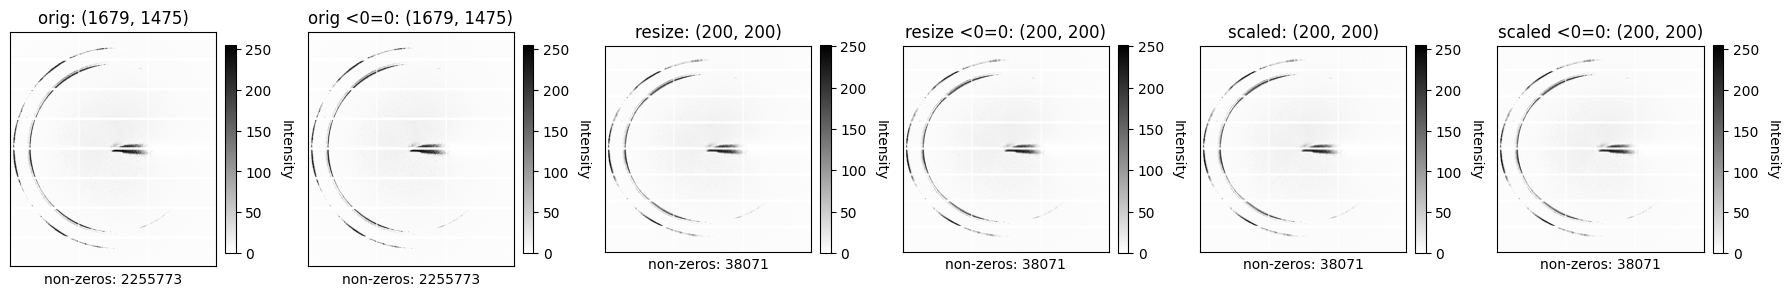

denoised images_cleaned[0]: (1679, 1475): {'Mean': 8, 'Median': 4, 'Min': 1, '5th %': 1, '10th %': 2, '25th %': 2, '50th %': 4, '75th %': 7, '90th %': 11, '95th %': 14, 'Max': 255}
denoised small_images[0]: (200, 200): {'Mean': 8, 'Median': 4, 'Min': 1, '5th %': 2, '10th %': 3, '25th %': 3, '50th %': 4, '75th %': 7, '90th %': 11, '95th %': 14, 'Max': 251}
denoised small_images_scaled[0]: (200, 200): {'Mean': 8, 'Median': 4, 'Min': 1, '5th %': 2, '10th %': 3, '25th %': 3, '50th %': 4, '75th %': 7, '90th %': 11, '95th %': 14, 'Max': 255}


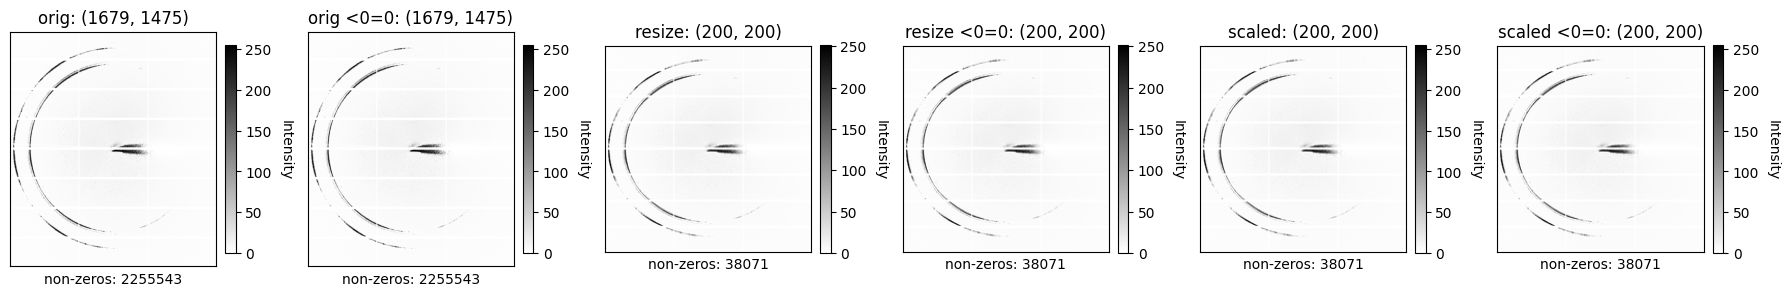

images_cleaned[1]: (1679, 1475): {'Mean': 6, 'Median': 4, 'Min': 1, '5th %': 2, '10th %': 2, '25th %': 2, '50th %': 4, '75th %': 7, '90th %': 11, '95th %': 14, 'Max': 255}
small_images[1]: (200, 200): {'Mean': 6, 'Median': 4, 'Min': 1, '5th %': 2, '10th %': 3, '25th %': 3, '50th %': 4, '75th %': 7, '90th %': 11, '95th %': 13, 'Max': 225}
small_images_scaled[1]: (200, 200): {'Mean': 7, 'Median': 4, 'Min': 1, '5th %': 2, '10th %': 3, '25th %': 3, '50th %': 4, '75th %': 7, '90th %': 12, '95th %': 14, 'Max': 255}


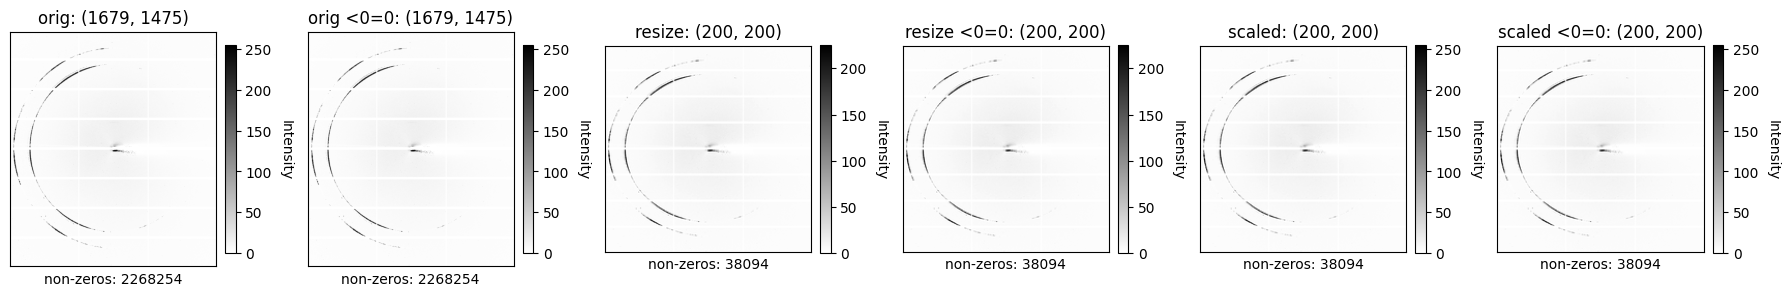

denoised images_cleaned[1]: (1679, 1475): {'Mean': 6, 'Median': 4, 'Min': 1, '5th %': 2, '10th %': 2, '25th %': 2, '50th %': 4, '75th %': 7, '90th %': 11, '95th %': 14, 'Max': 255}
denoised small_images[1]: (200, 200): {'Mean': 6, 'Median': 4, 'Min': 1, '5th %': 2, '10th %': 3, '25th %': 3, '50th %': 4, '75th %': 7, '90th %': 11, '95th %': 13, 'Max': 225}
denoised small_images_scaled[1]: (200, 200): {'Mean': 7, 'Median': 4, 'Min': 1, '5th %': 2, '10th %': 3, '25th %': 3, '50th %': 4, '75th %': 7, '90th %': 12, '95th %': 14, 'Max': 255}


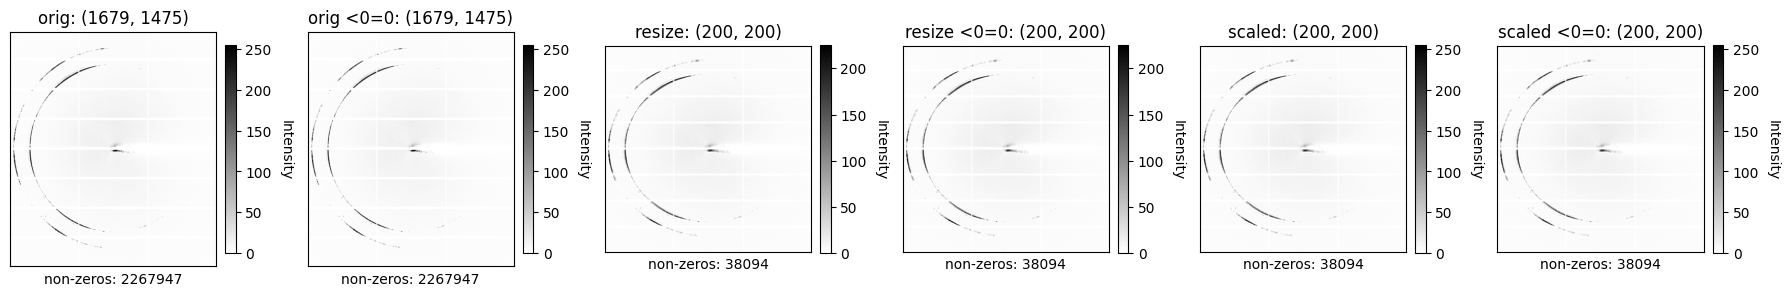

max images_cleaned[0]: (1679, 1475): {'Mean': 255, 'Median': 255, 'Min': 255, '5th %': 255, '10th %': 255, '25th %': 255, '50th %': 255, '75th %': 255, '90th %': 255, '95th %': 255, 'Max': 255}
max small_images[0]: (200, 200): {'Mean': 255, 'Median': 255, 'Min': 255, '5th %': 255, '10th %': 255, '25th %': 255, '50th %': 255, '75th %': 255, '90th %': 255, '95th %': 255, 'Max': 255}
max small_images_scaled[0]: (200, 200): {'Mean': 255, 'Median': 255, 'Min': 255, '5th %': 255, '10th %': 255, '25th %': 255, '50th %': 255, '75th %': 255, '90th %': 255, '95th %': 255, 'Max': 255}


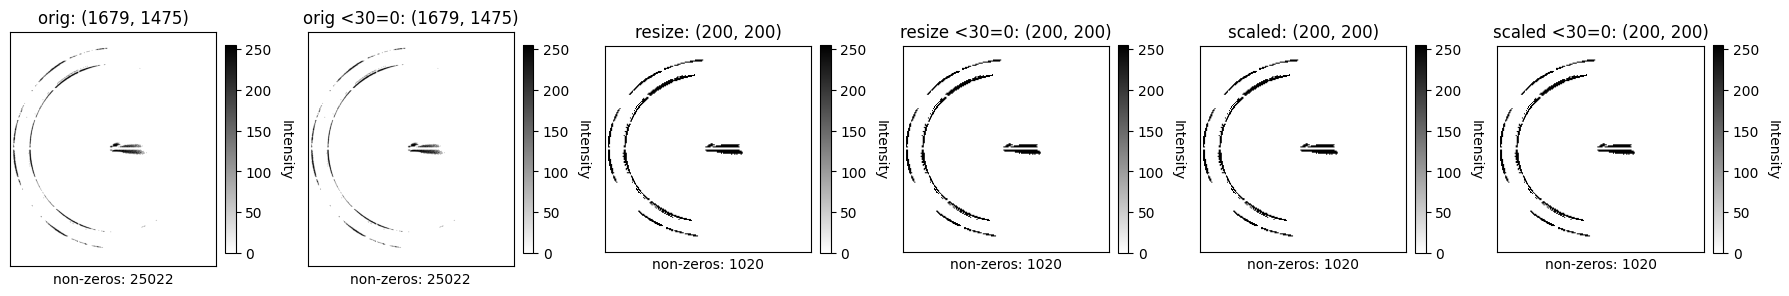

max images_cleaned[1]: (1679, 1475): {'Mean': 255, 'Median': 255, 'Min': 255, '5th %': 255, '10th %': 255, '25th %': 255, '50th %': 255, '75th %': 255, '90th %': 255, '95th %': 255, 'Max': 255}
max small_images[1]: (200, 200): {'Mean': 255, 'Median': 255, 'Min': 255, '5th %': 255, '10th %': 255, '25th %': 255, '50th %': 255, '75th %': 255, '90th %': 255, '95th %': 255, 'Max': 255}
max small_images_scaled[1]: (200, 200): {'Mean': 255, 'Median': 255, 'Min': 255, '5th %': 255, '10th %': 255, '25th %': 255, '50th %': 255, '75th %': 255, '90th %': 255, '95th %': 255, 'Max': 255}


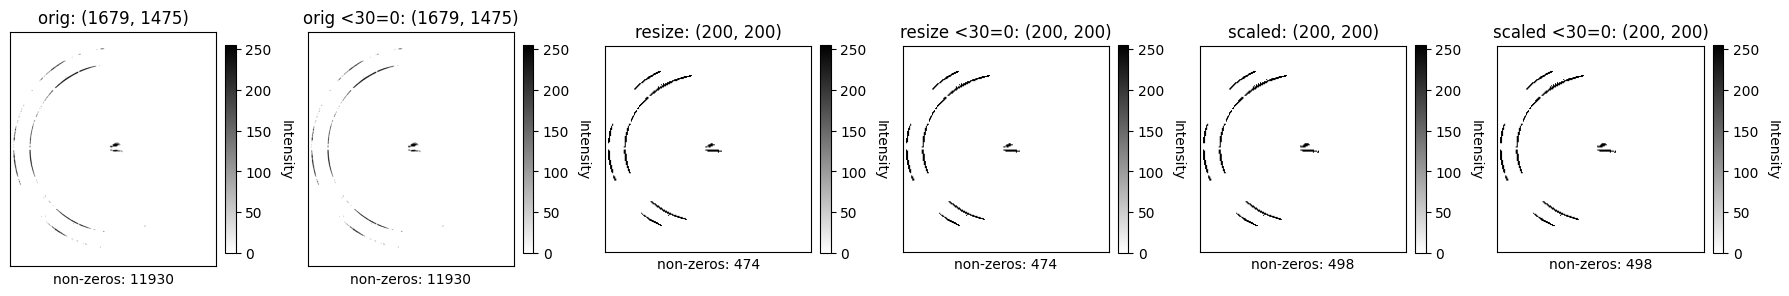

images_cleaned: {'Mean': 12, 'Median': 5, 'Min': 1, '5th %': 1, '10th %': 1, '25th %': 2, '50th %': 5, '75th %': 9, '90th %': 17, '95th %': 28, 'Max': 255}
small_images: {'Mean': 11, 'Median': 5, 'Min': 1, '5th %': 2, '10th %': 2, '25th %': 3, '50th %': 5, '75th %': 12, '90th %': 22, '95th %': 37, 'Max': 255}
small_images_scaled: {'Mean': 15, 'Median': 6, 'Min': 1, '5th %': 2, '10th %': 2, '25th %': 3, '50th %': 6, '75th %': 17, '90th %': 35, '95th %': 57, 'Max': 255}


In [ ]:
# Test thoery for removing the background noise for METAL IMAGES (DOES THIS WORK? ARE ALL BLANK IMAGES THE SAME? )
# new_size = images_blank.shape[0]
# width, height = images_blank[0].shape
# images_rings_reduced = np.zeros((new_size, width, height))
# for i in range(new_size):
#    images_rings_reduced[i] = images_rings[i]

images_cleaned = images_rings - images_blank
images_cleaned = 255 - images_cleaned

# 0 (black) to 255 (white)
original_images = np.array(images_cleaned)
small_images = resizeImages(original_images)
# Fix the images: local min-max scaling (i.e. (i.e. current value = 57, local max value = 57, then (57-0)/(57-0)*255=255, current value = 5, then (5-0)/(57-0)*255=22))
small_images_scaled = np.array([img / np.max(img) * 255 if np.max(img) != 0 else img for img in small_images])

# plot two images for visualization, then plot another two images with noise removed for visualization
for i, (orig_img, resized_img, scaled_img) in enumerate(zip(original_images, small_images, small_images_scaled)):
    if i < 2:
        print(f"images_cleaned[{i}]: {orig_img.shape}: {analyze_pixel_intensity(orig_img, 0)}")
        print(f"small_images[{i}]: {resized_img.shape}: {analyze_pixel_intensity(resized_img, 0)}")
        print(f"small_images_scaled[{i}]: {scaled_img.shape}: {analyze_pixel_intensity(scaled_img, 0)}")
        plot_image(orig_img, resized_img, scaled_img, 0, False, True)

        # Apply 3x3 components to remove noises
        orig_img = remove_noise(orig_img, threshold=0)
        resized_img = remove_noise(resized_img, threshold=0)
        scaled_img = remove_noise(scaled_img, threshold=0)

        print(f"denoised images_cleaned[{i}]: {orig_img.shape}: {analyze_pixel_intensity(orig_img, 0)}")
        print(f"denoised small_images[{i}]: {resized_img.shape}: {analyze_pixel_intensity(resized_img, 0)}")
        print(f"denoised small_images_scaled[{i}]: {scaled_img.shape}: {analyze_pixel_intensity(scaled_img, 0)}")
        plot_image(orig_img, resized_img, scaled_img, 0, False, True)

# plot another two images by setting any pixels that are not zero to 255!!!  THIS WILL MAKE THE WHO IMAGE 255
for i, (orig_img, resized_img, scaled_img) in enumerate(zip(original_images, small_images, small_images_scaled)):
   if i < 2:
      # Apply 3x3 components plus threshold of 4 (any value that is <=4 and not not in 3x3 is reset to 0)
      orig_img = remove_noise(orig_img, threshold=30)
      resized_img = remove_noise(resized_img, threshold=30)
      scaled_img = remove_noise(scaled_img, threshold=30)

      # Any remaining pixels that not zero is set to 255
      orig_img[orig_img>0]=255
      resized_img[resized_img>0]=255
      scaled_img[scaled_img>0]=255

      print(f"max images_cleaned[{i}]: {orig_img.shape}: {analyze_pixel_intensity(orig_img, 0)}")
      print(f"max small_images[{i}]: {resized_img.shape}: {analyze_pixel_intensity(resized_img, 0)}")
      print(f"max small_images_scaled[{i}]: {scaled_img.shape}: {analyze_pixel_intensity(scaled_img, 0)}")
      plot_image(orig_img, resized_img, scaled_img, 30, False, True)

# New analysis code to look at overall distribution in 700 images
print(f"images_cleaned: {analyze_pixel_intensity(original_images, 0)}")
print(f"small_images: {analyze_pixel_intensity(small_images, 0)}")
print(f"small_images_scaled: {analyze_pixel_intensity(small_images_scaled, 0)}")

Analyzing images_cleaned statistics - Based on number of pixels rather than number of rings, but should infer number of rings
# images: 350 Mean number of dots: 179.33 Median: 121.0 Highest count: 733 Lowest count: 1


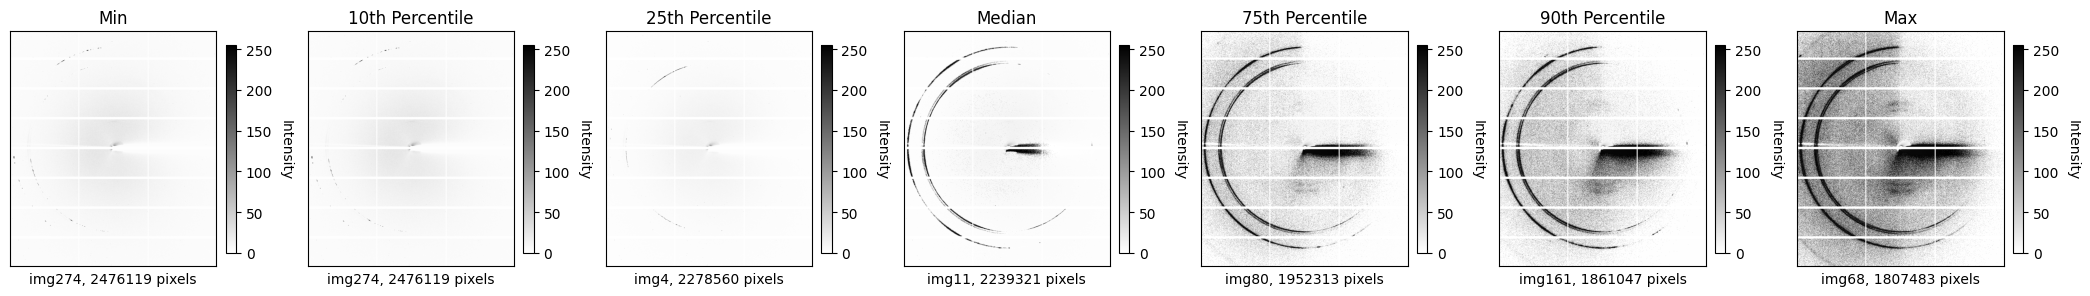

# images: 350 Mean number of dots: 3.22 Median: 3.0 Highest count: 9 Lowest count: 1


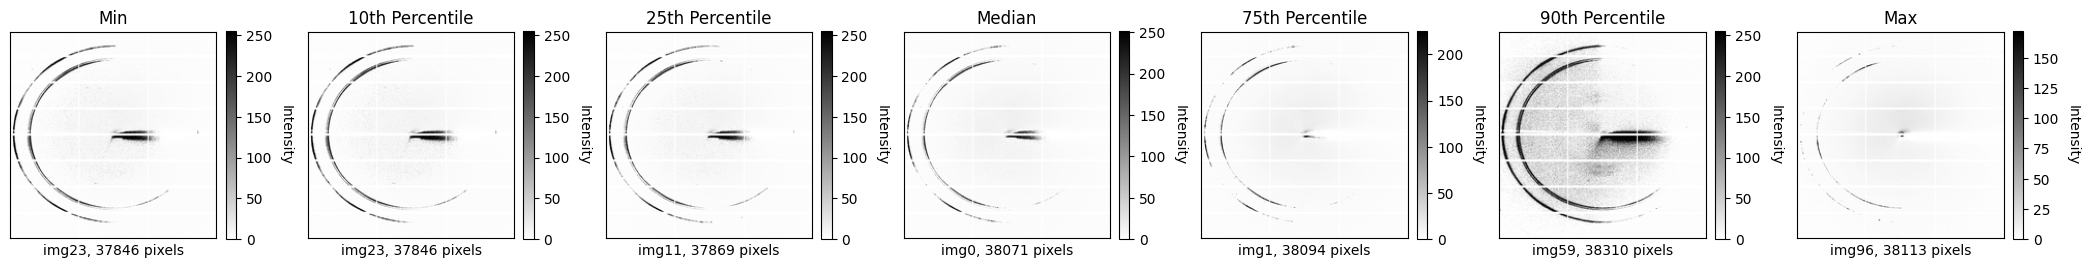

# images: 350 Mean number of dots: 3.22 Median: 3.0 Highest count: 9 Lowest count: 1


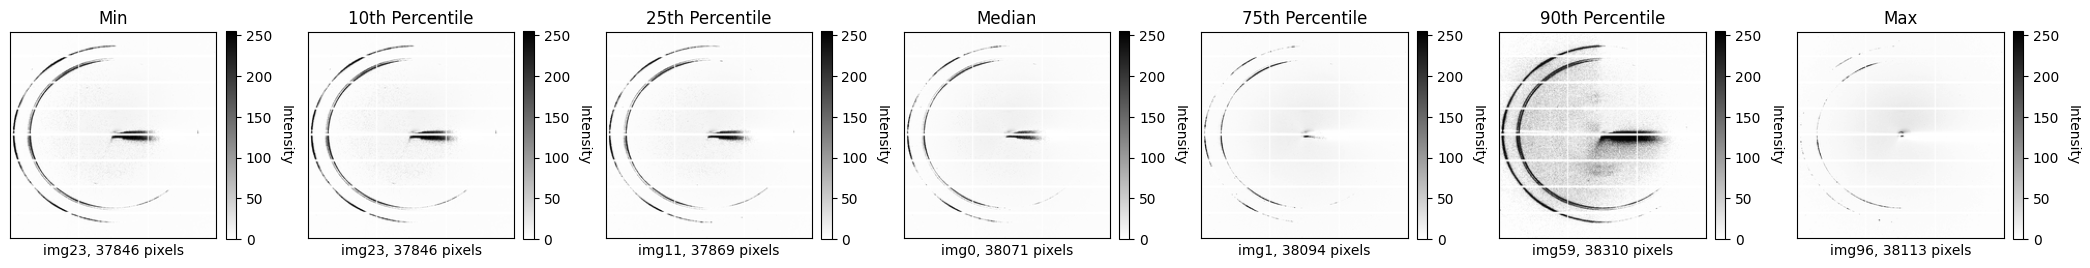

In [ ]:
print(f"Analyzing images_cleaned statistics - Based on number of pixels rather than number of rings, but should infer number of rings")
plot_dot_image_list_statistics(original_images, 0, False, True)
plot_dot_image_list_statistics(small_images, 0, False, True)
plot_dot_image_list_statistics(small_images_scaled, 0, False, True) # did not scale all non-zeros to 255

In [ ]:
# Archive code to fix the image (unsure if it makes sense)
print(f"Identify loaded images")
print(f"images_dots.shape[0]: {images_dots.shape[0]}")
print(f"images_rings.shape[0]: {images_rings.shape[0]}")
print(f"images_blank.shape[0]: {images_blank.shape[0]}")
# images_rings = images_rings / 255.0  # Normalize the images (NOT NEEDED)

# find out the pixel values of each images
print(f"max: {np.max(images_dots[0])} min: {np.min(images_dots[0])} non-zeros: {np.count_nonzero(images_dots[0])}")
print(f"max: {np.max(images_rings[0])} min: {np.min(images_rings[0])} non-zeros: {np.count_nonzero(images_rings[0])}")
# print(f"max: {np.max(images_blank[0])} min: {np.min(images_blank[0])} non-zeros: {np.count_nonzero(images_blank[0])}")

# new_size = images_dots.shape[0]
new_size = images_rings.shape[0]

# Initialize an empty array to hold the averaged images of 370
images_dots_reduced = np.zeros((new_size, 200, 200))

# Perform averaging in groups of 'factor'
for i in range(new_size):
    images_dots_reduced[i] = images_dots[i]

# Fix the images - how does it work exactly, build the formula and get the actual values.
print(f"\nRun min-max normalization on the images...")
images_dots_reduced = (images_dots_reduced - np.min(images_dots_reduced)) / (np.max(images_dots_reduced) - np.min(images_dots_reduced))
images_rings_reduced = (images_rings - np.min(images_rings)) / (np.max(images_rings) - np.min(images_rings))

print(f"images_dots_reduced - max: {np.max(images_dots_reduced)} min: {np.min(images_dots_reduced)} non-zeros: {np.count_nonzero(images_dots_reduced)}")
print(f"images_dots_reduced[0] - max: {np.max(images_dots_reduced[0])} min: {np.min(images_dots_reduced[0])} non-zeros: {np.count_nonzero(images_dots_reduced[0])}")
print(f"images_rings_reduced - max: {np.max(images_rings_reduced)} min: {np.min(images_rings_reduced)} non-zeros: {np.count_nonzero(images_rings_reduced)}")
print(f"images_rings_reduced[0] - max: {np.max(images_rings_reduced[0])} min: {np.min(images_rings_reduced[0])} non-zeros: {np.count_nonzero(images_rings_reduced[0])}")

# HACK! Ask Yang for suggestions
print(f"\nStrengthen the dots and ring intensities...")
# Approach 1: apply a local scaling but lead to a loss of relative intensity information between images.
images_dots_scaled = np.array([img / np.max(img) if np.max(img) != 0 else img for img in images_dots_reduced])
images_rings_scaled = np.array([img / np.max(img) if np.max(img) != 0 else img for img in images_rings_reduced])

# Approach 2: apply a non-linear scaling to enhance the contrast in images (NOT WORKING WELL, CHECK!!)
# images_dots_adaptive = np.log1p(images_dots_reduced)  # Logarithmic scaling
# images_dots_adaptive = images_dots_adaptive / np.max(images_dots_adaptive)
# images_rings_adaptive = np.log1p(images_rings_reduced)  # Logarithmic scaling
# images_rings_adaptive = images_rings_adaptive / np.max(images_rings_adaptive)

print(f"images_dots_scaled - max: {np.max(images_dots_scaled)} min: {np.min(images_dots_scaled)} non-zeros: {np.count_nonzero(images_dots_scaled)}")
print(f"images_dots_scaled[0] - max: {np.max(images_dots_scaled[0])} min: {np.min(images_dots_scaled[0])} non-zeros: {np.count_nonzero(images_dots_scaled[0])}")
# print(f"images_dots_adaptive - max: {np.max(images_dots_adaptive)} min: {np.min(images_dots_adaptive)} non-zeros: {np.count_nonzero(images_dots_adaptive)}")
# print(f"images_dots_adaptive[0] - max: {np.max(images_dots_adaptive[0])} min: {np.min(images_dots_adaptive[0])} non-zeros: {np.count_nonzero(images_dots_adaptive[0])}")
print(f"images_rings_scaled - max: {np.max(images_rings_scaled)} min: {np.min(images_rings_scaled)} non-zeros: {np.count_nonzero(images_rings_scaled)}")
print(f"images_rings_scaled[0] - max: {np.max(images_rings_scaled[0])} min: {np.min(images_rings_scaled[0])} non-zeros: {np.count_nonzero(images_rings_scaled[0])}")
# print(f"images_rings_adaptive - max: {np.max(images_rings_adaptive)} min: {np.min(images_rings_adaptive)} non-zeros: {np.count_nonzero(images_rings_adaptive)}")
# print(f"images_rings_adaptive[0] - max: {np.max(images_rings_adaptive[0])} min: {np.min(images_rings_adaptive[0])} non-zeros: {np.count_nonzero(images_rings_adaptive[0])}")

# Combined ring and dot images to create an overlapping image
print(f"\nCombine to create dots and ring images...")
images_combined_reduced = images_rings_reduced + images_dots_reduced
images_combined_scaled = images_rings_scaled + images_dots_scaled
# print(f"images_combined - max: {np.max(images_combined)} min: {np.min(images_combined)} non-zeros: {np.count_nonzero(images_combined)}")
# print(f"images_combined[0] - max: {np.max(images_combined[0])} min: {np.min(images_combined[0])} non-zeros: {np.count_nonzero(images_combined[0])}")

print(f"Plotting processed images")
Plot(images_dots_reduced, 5, None, True)
Plot(images_rings_reduced, 5, None, True)
Plot(images_overlay, 5, None, True)